Epoch 1/50


2023-11-12 10:31:13.533131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-12 10:31:13.533986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-12 10:31:13.534431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

116/116 [==============================] - 6s 39ms/step - loss: 0.0154
Epoch 2/50
116/116 [==============================] - 4s 38ms/step - loss: 0.0098
Epoch 3/50
116/116 [==============================] - 4s 38ms/step - loss: 0.0078
Epoch 4/50
116/116 [==============================] - 4s 37ms/step - loss: 0.0066
Epoch 5/50
116/116 [==============================] - 4s 37ms/step - loss: 0.0050
Epoch 6/50
116/116 [==============================] - 4s 36ms/step - loss: 0.0045
Epoch 7/50
116/116 [==============================] - 4s 37ms/step - loss: 0.0041
Epoch 8/50
116/116 [==============================] - 4s 36ms/step - loss: 0.0041
Epoch 9/50
116/116 [==============================] - 4s 37ms/step - loss: 0.0040
Epoch 10/50
116/116 [==============================] - 4s 38ms/step - loss: 0.0040
Epoch 11/50
116/116 [==============================] - 5s 40ms/step - loss: 0.0040
Epoch 12/50
116/116 [==============================] - 5s 43ms/step - loss: 0.0040
Epoch 13/50
116/116 [===

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-12 10:35:14.956963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-12 10:35:14.957537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-12 10:35:14.958122: I tensor

13/13 [==============================] - 0s 17ms/step


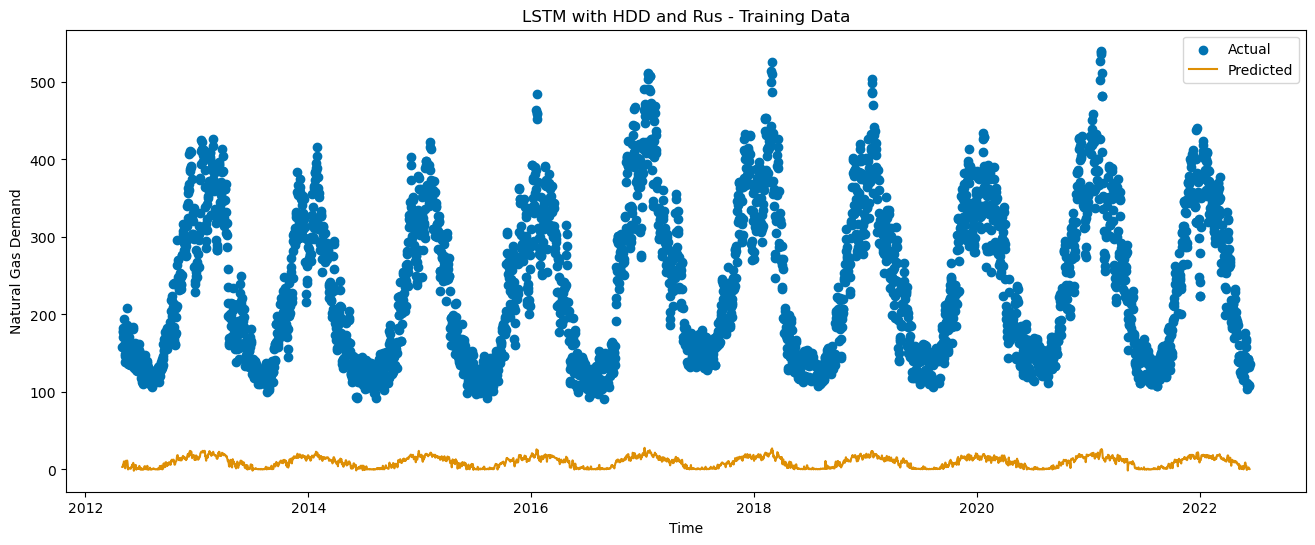

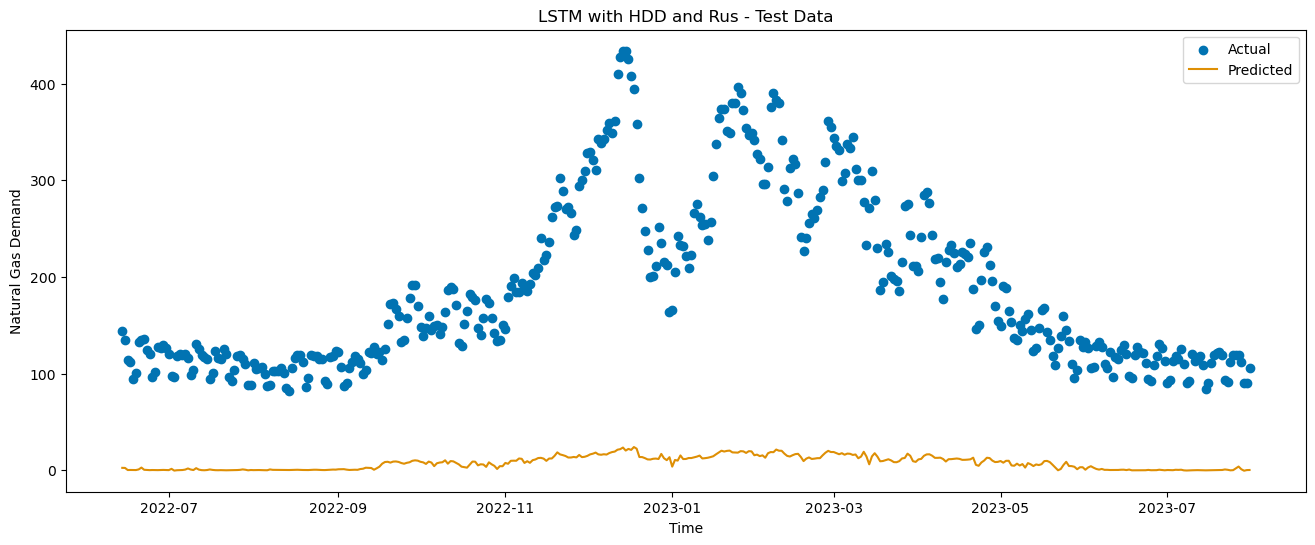

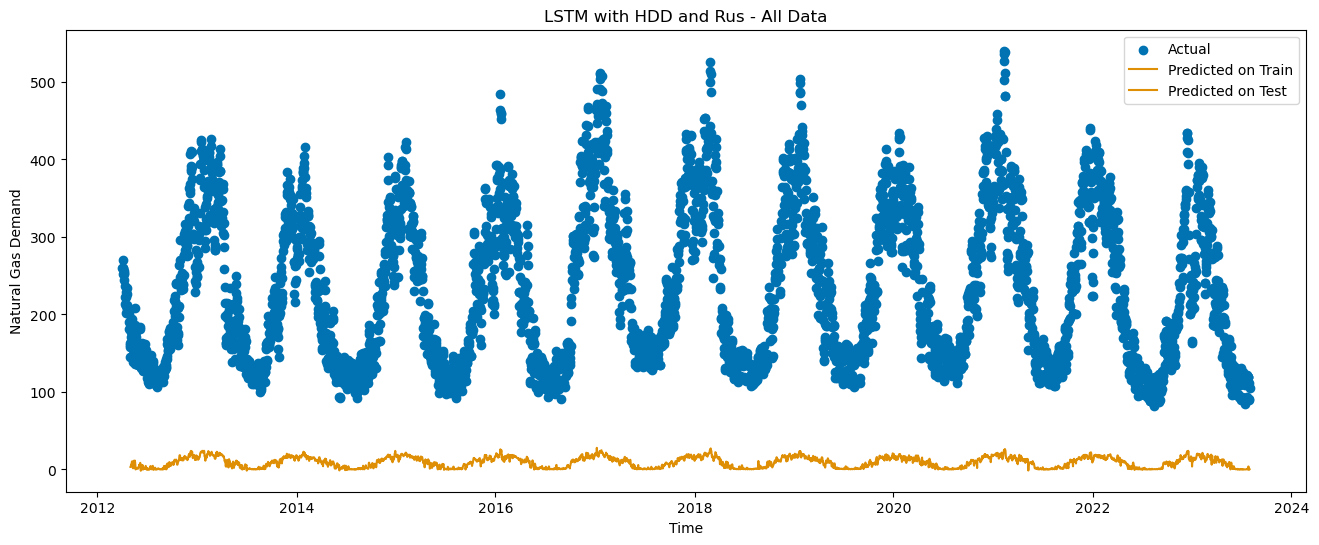

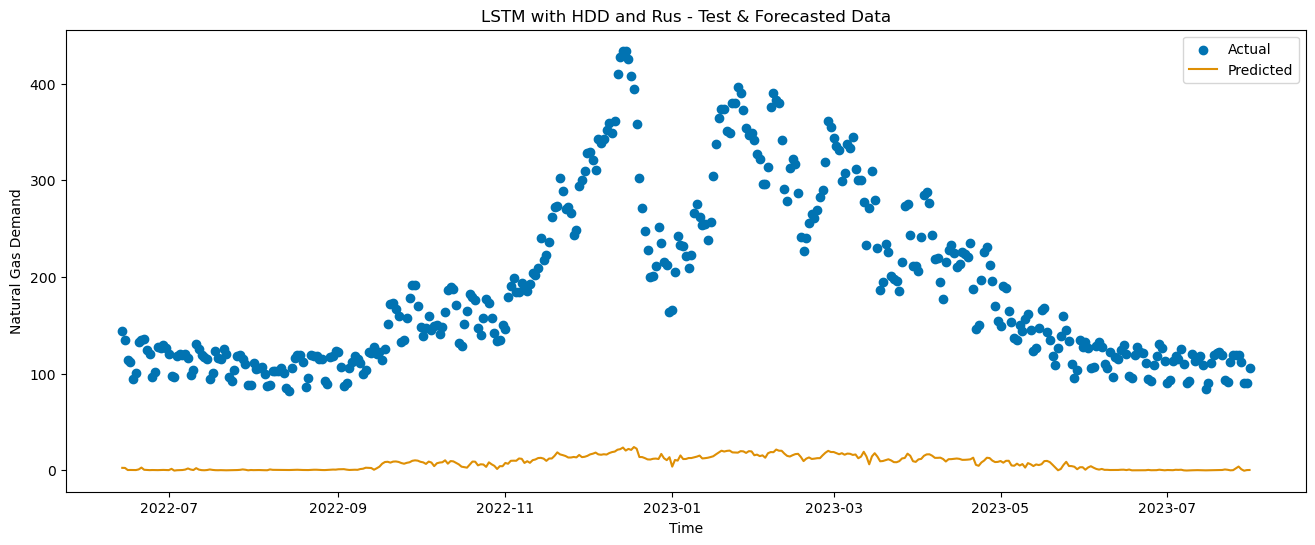

1/1 [==============================] - 0s 10ms/step


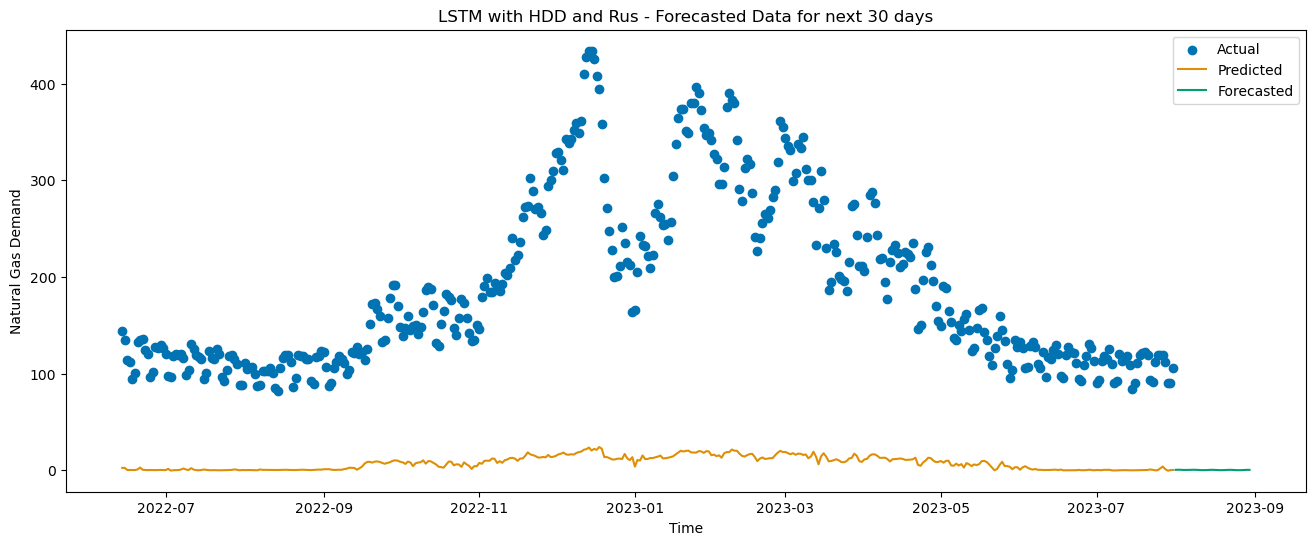

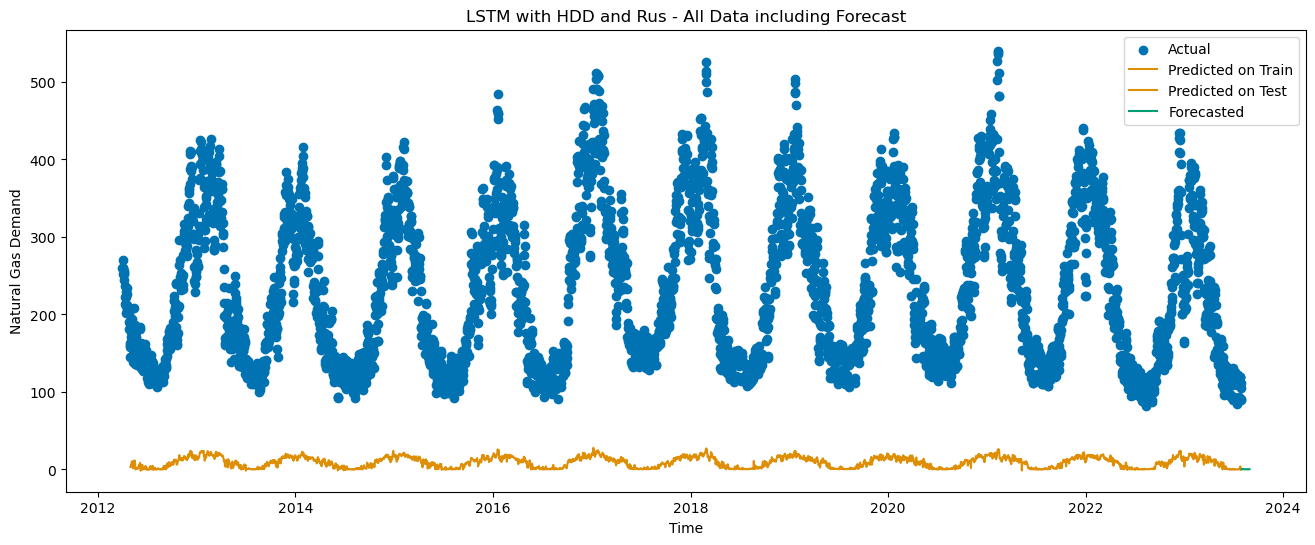

Execution Time for NGD - LSTM with HDD and Rus: 245.27 seconds
Evaluation based on variables: ['HDD', 'HDD-1', 'Rus', 'War', 'Workday', 'Month', 'DE IND index']
Training MAPE: 96.5272%
Testing MAPE: 96.7310%
Training RMSE: 243.8843
Testing RMSE: 199.0376
Training R2 score: -5.2087
Testing R2 score: -4.1129
Training MAE: 226.0619
Testing MAE: 181.5119


In [2]:
# LTSM with multiple explanatory variables
# NGD 300

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from prophet import Prophet
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 30
type_ngd = 'NGD'

variables_dict = {
    'NGD': ['HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index'],
    'LDZ': ['HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','FR nuclear'],
    'IND': ['HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','DE IND index', 'FR nuclear','THE price'],
    'GTP': ['HDD', 'HDD-1', 'Rus','War','Month','DE wind','DE solar','FR nuclear','EU storage','EU LNG','THE price','DE IND index','UK NL production','African TAP']
}

if type_ngd not in variables_dict:
    raise ValueError("Invalid gas demand type selected!")

explanatory_vars = variables_dict[type_ngd]

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-04 22:53:15.337147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 22:53:15.337675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 22:53:15.338491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

106/106 [==============================] - 50s 455ms/step - loss: 0.0114
Epoch 2/50
106/106 [==============================] - 46s 438ms/step - loss: 0.0050
Epoch 3/50
106/106 [==============================] - 46s 437ms/step - loss: 0.0038
Epoch 4/50
106/106 [==============================] - 46s 437ms/step - loss: 0.0034
Epoch 5/50
106/106 [==============================] - 46s 438ms/step - loss: 0.0030
Epoch 6/50
106/106 [==============================] - 46s 438ms/step - loss: 0.0025
Epoch 7/50
106/106 [==============================] - 46s 438ms/step - loss: 0.0024
Epoch 8/50
106/106 [==============================] - 46s 432ms/step - loss: 0.0020
Epoch 9/50
106/106 [==============================] - 46s 432ms/step - loss: 0.0021
Epoch 10/50
106/106 [==============================] - 46s 433ms/step - loss: 0.0017
Epoch 11/50
106/106 [==============================] - 46s 431ms/step - loss: 0.0017
Epoch 12/50
106/106 [==============================] - 46s 433ms/step - loss: 0.0016


/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-04 23:49:10.151057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 23:49:10.151630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 23:49:10.152153: I tensor

13/13 [==============================] - 2s 126ms/step


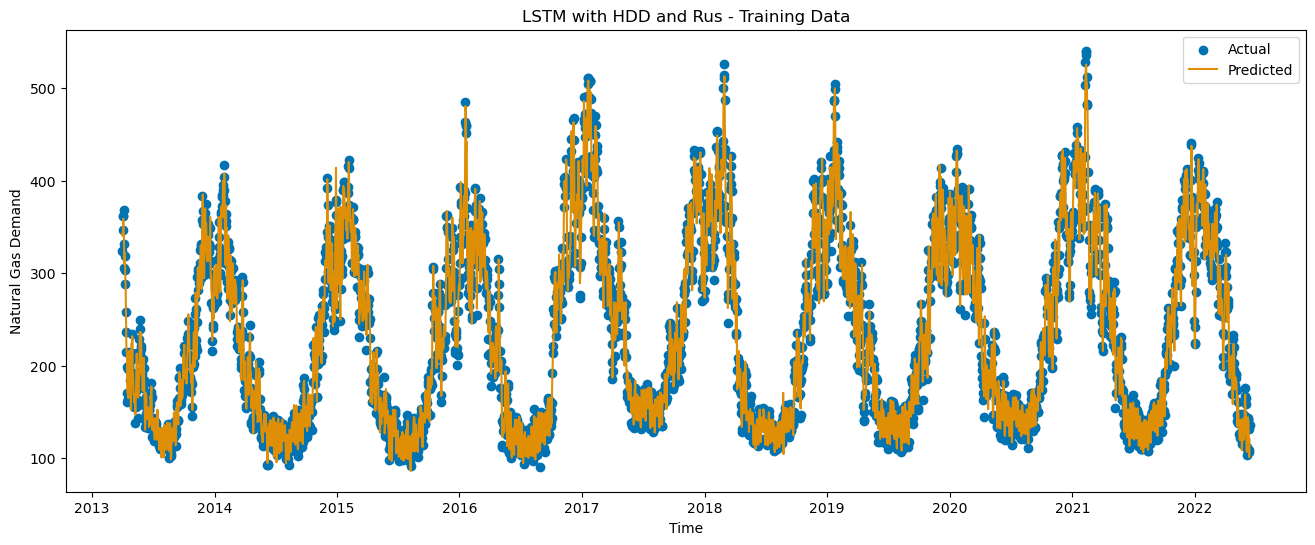

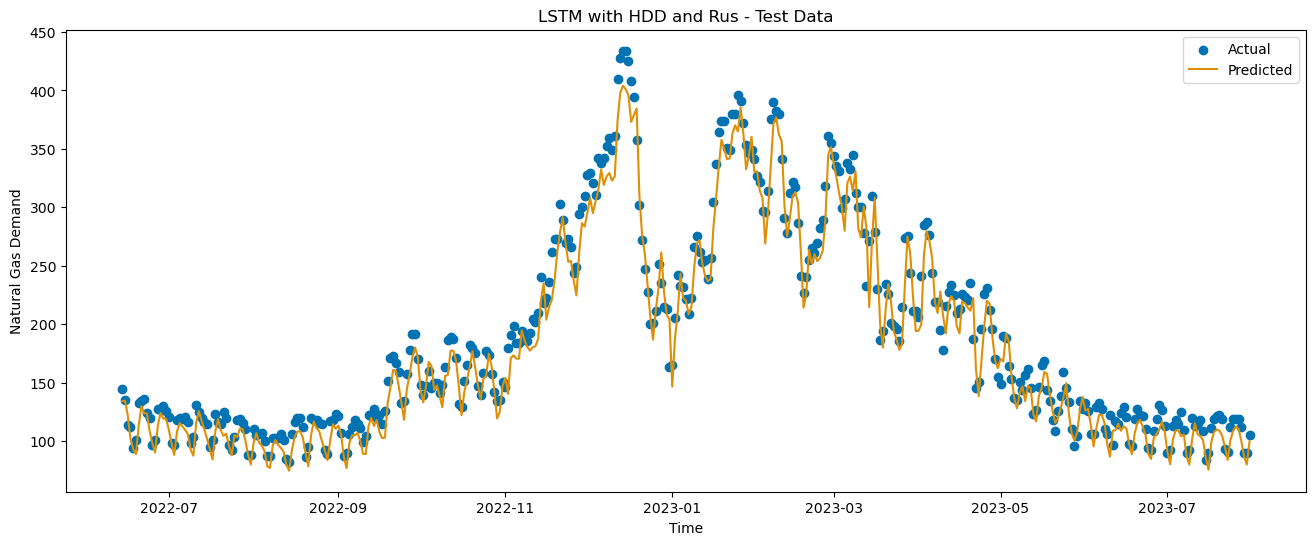

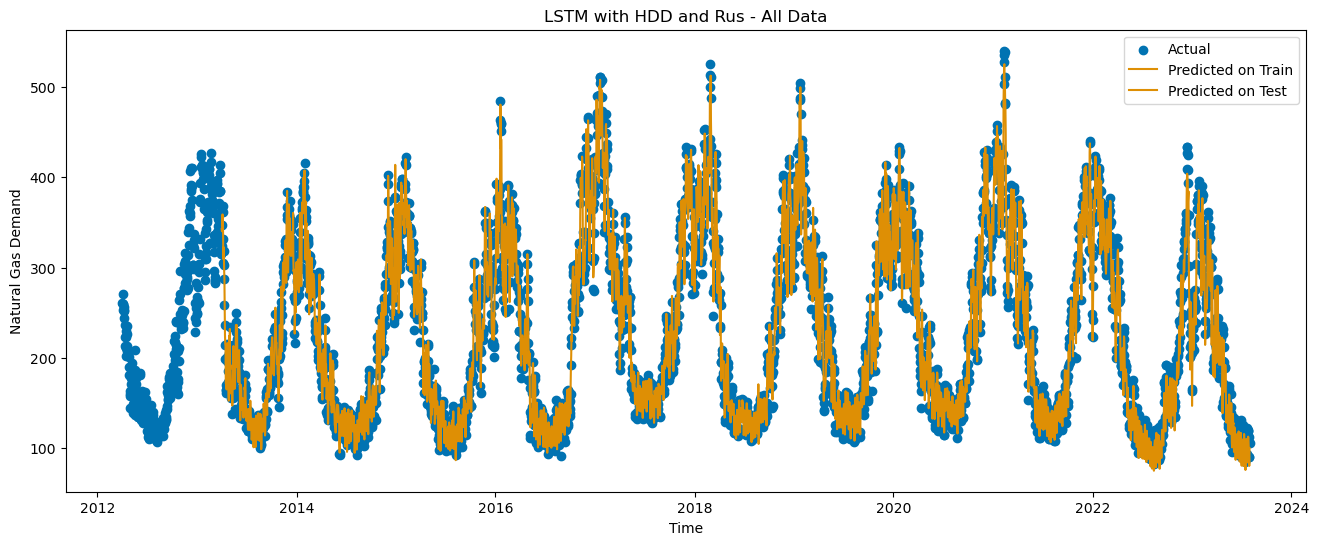

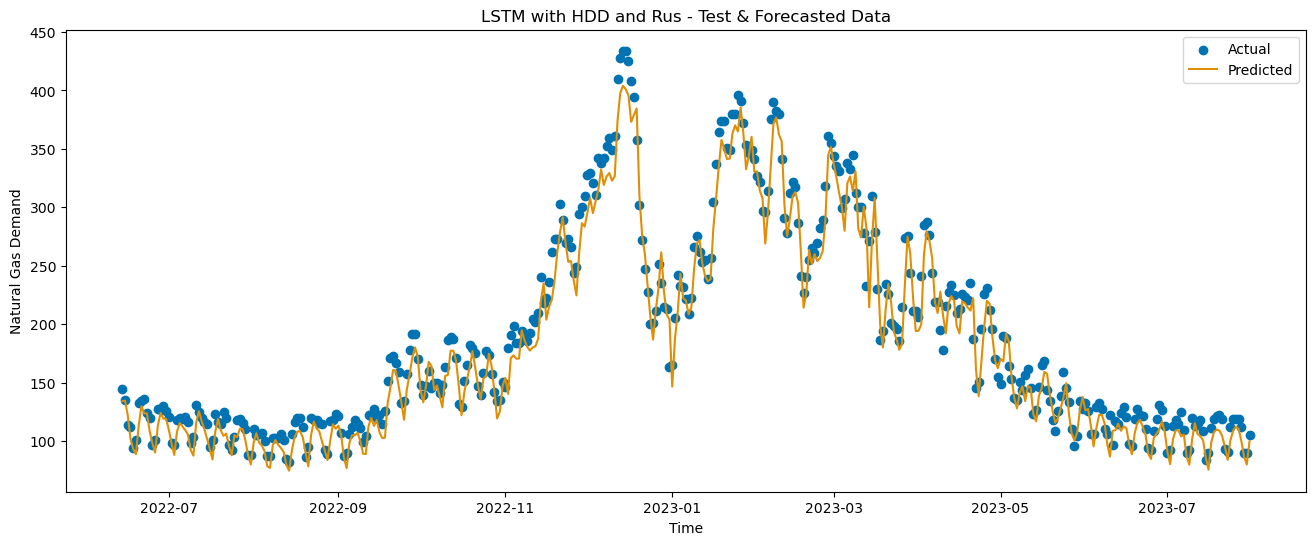

1/1 [==============================] - 0s 28ms/step


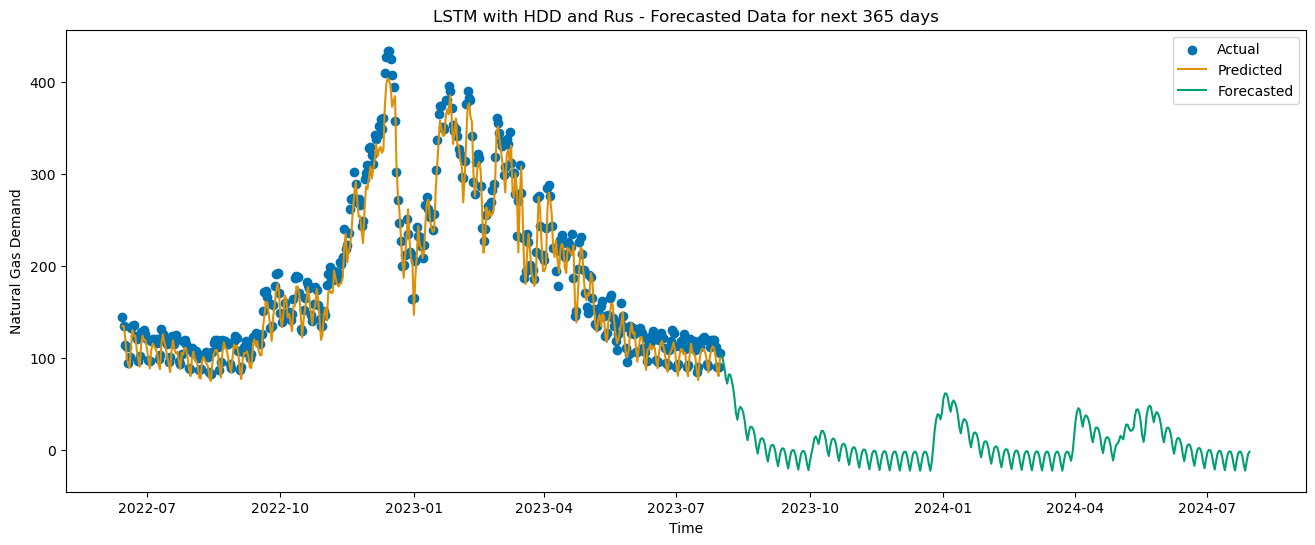

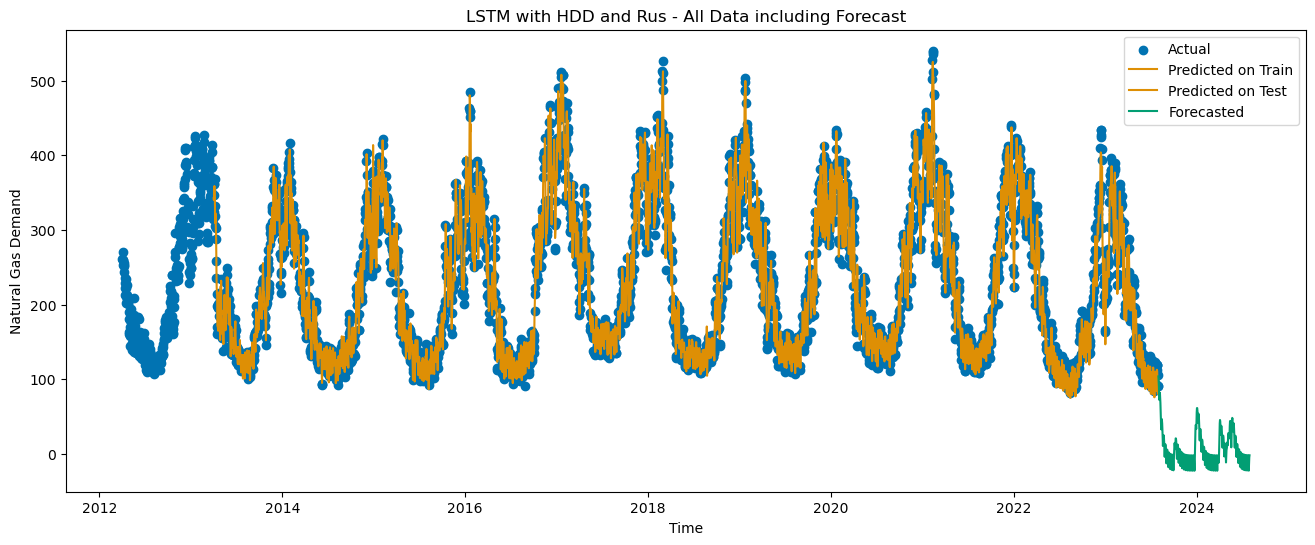

Execution Time for NGD - LSTM with HDD and Rus: 3405.30 seconds
Evaluation based on variables: ['NGD', 'HDD', 'HDD-1', 'Rus', 'War', 'Workday', 'Month', 'DE IND index']
Training MAPE: 4.5753%
Testing MAPE: 6.9922%
Training RMSE: 14.1176
Testing RMSE: 15.8453
Training R2 score: 0.9791
Testing R2 score: 0.9676
Training MAE: 10.3107
Testing MAE: 12.6391


In [39]:
# LTSM with multiple explanatory variables
# NGD 300

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 365
type_ngd = 'NGD'
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','EU storage','DE solar','EU LNG','THE price', 'DE IND index','EU LNG','UK NL production','African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','DE IND index', 'FR nuclear','THE price']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-04 23:50:00.661758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 23:50:00.662276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 23:50:00.663023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

116/116 [==============================] - 5s 36ms/step - loss: 0.0098
Epoch 2/50
116/116 [==============================] - 4s 37ms/step - loss: 0.0052
Epoch 3/50
116/116 [==============================] - 4s 36ms/step - loss: 0.0035
Epoch 4/50
116/116 [==============================] - 4s 36ms/step - loss: 0.0028
Epoch 5/50
116/116 [==============================] - 4s 35ms/step - loss: 0.0025
Epoch 6/50
116/116 [==============================] - 4s 36ms/step - loss: 0.0022
Epoch 7/50
116/116 [==============================] - 4s 38ms/step - loss: 0.0019
Epoch 8/50
116/116 [==============================] - 25s 215ms/step - loss: 0.0018
Epoch 9/50
116/116 [==============================] - 4s 38ms/step - loss: 0.0018
Epoch 10/50
116/116 [==============================] - 4s 36ms/step - loss: 0.0016
Epoch 11/50
116/116 [==============================] - 4s 36ms/step - loss: 0.0016
Epoch 12/50
116/116 [==============================] - 4s 35ms/step - loss: 0.0015
Epoch 13/50
116/116 [=

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-04 23:54:22.807742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 23:54:22.808328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 23:54:22.808965: I tensor

  7/116 [>.............................] - ETA: 0s 

2023-11-04 23:54:22.897892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 23:54:22.898552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 23:54:22.899232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 0s 11ms/step


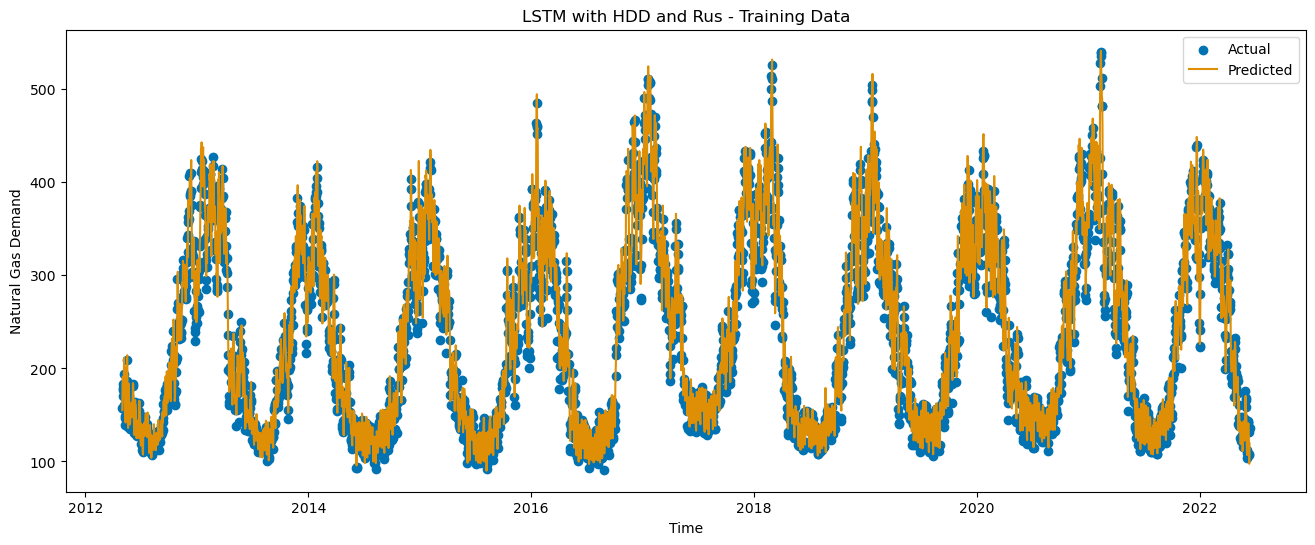

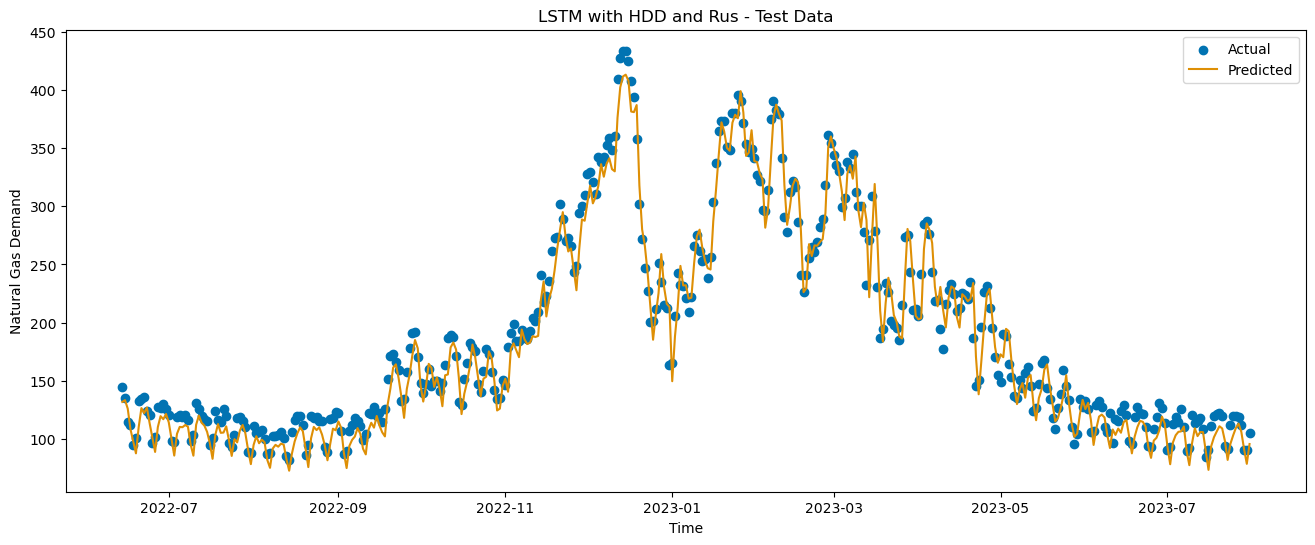

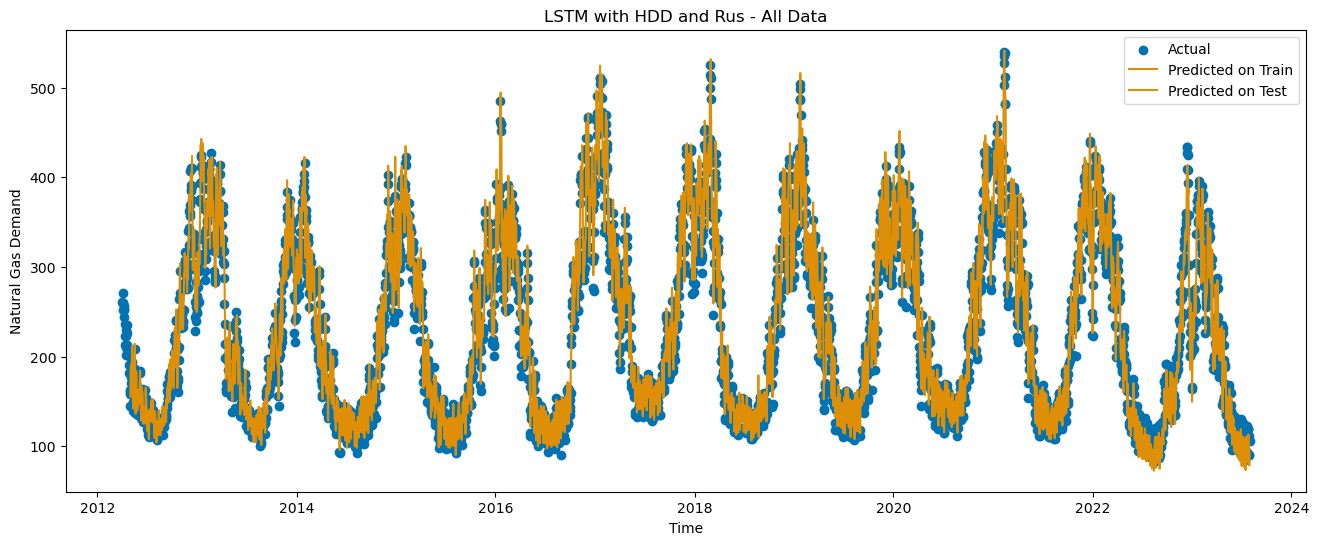

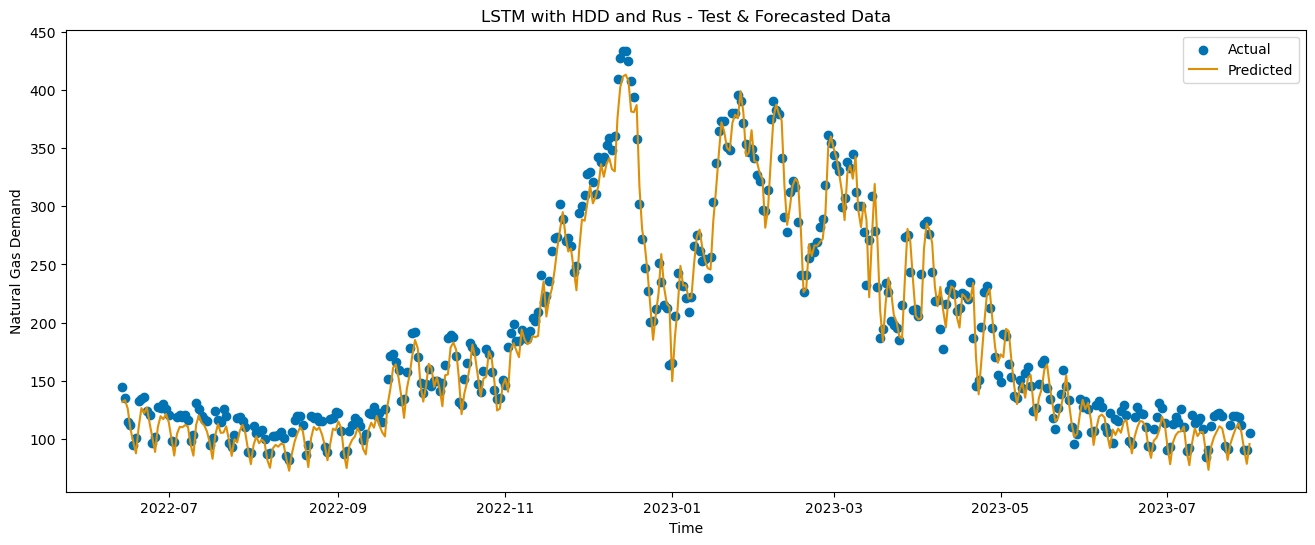

1/1 [==============================] - 0s 10ms/step


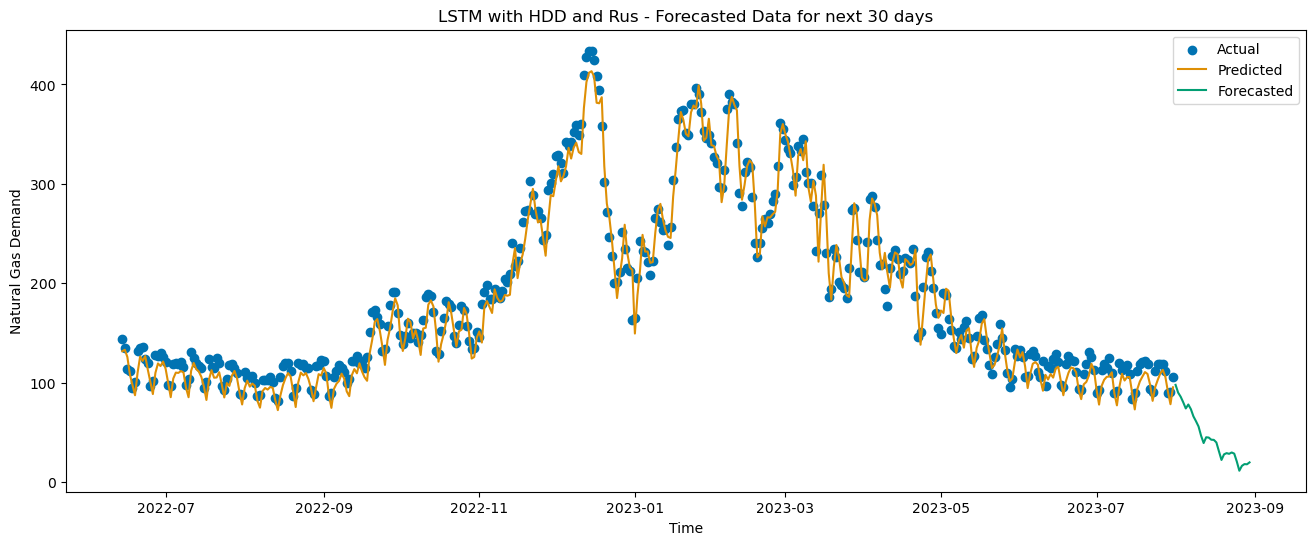

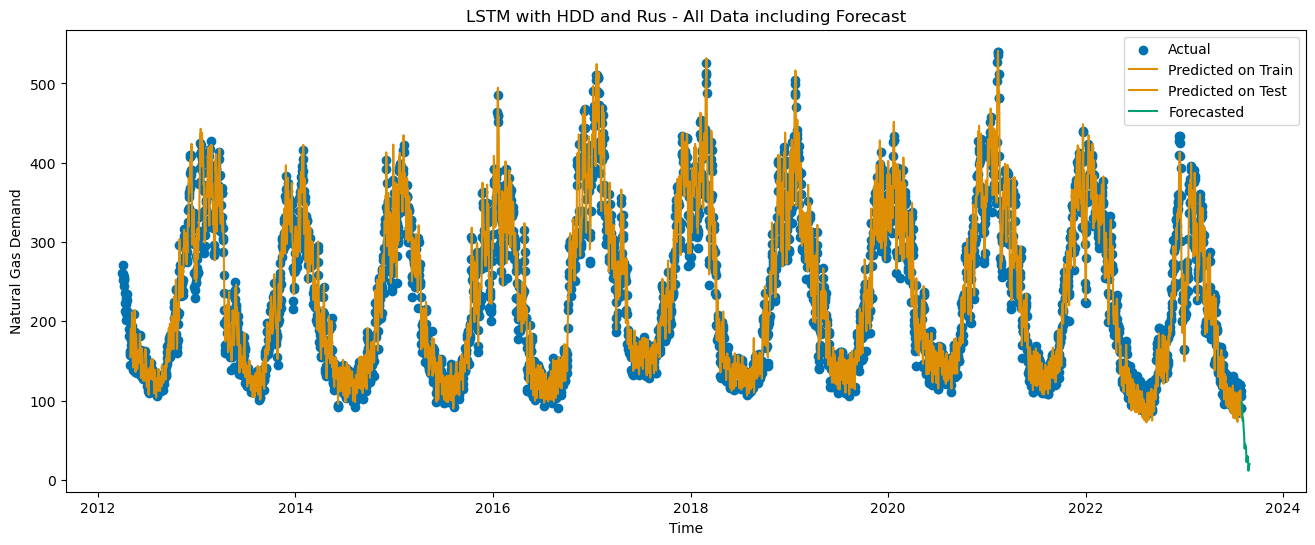

Execution Time for NGD - LSTM with HDD and Rus: 416.76 seconds
Evaluation based on variables: ['NGD', 'HDD', 'HDD-1', 'Rus', 'War', 'Workday', 'Month', 'DE IND index']
Training MAPE: 5.2818%
Testing MAPE: 7.3768%
Training RMSE: 15.7483
Testing RMSE: 15.7458
Training R2 score: 0.9741
Testing R2 score: 0.9680
Training MAE: 11.7299
Testing MAE: 12.6126


In [40]:
# LTSM with multiple explanatory variables
# NGD 30

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 30
type_ngd = 'NGD'
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','EU storage','DE solar','EU LNG','THE price', 'DE IND index','EU LNG','UK NL production','African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','DE IND index', 'FR nuclear','THE price']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-04 23:56:57.443616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 23:56:57.444300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 23:56:57.444781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 35s 434ms/step - loss: 0.0126
Epoch 2/50
77/77 [==============================] - 79s 1s/step - loss: 0.0047
Epoch 3/50
77/77 [==============================] - 180s 2s/step - loss: 0.0040
Epoch 4/50
77/77 [==============================] - 33s 431ms/step - loss: 0.0036
Epoch 5/50
77/77 [==============================] - 55s 724ms/step - loss: 0.0031
Epoch 6/50
77/77 [==============================] - 66s 859ms/step - loss: 0.0026
Epoch 7/50
77/77 [==============================] - 38s 495ms/step - loss: 0.0023
Epoch 8/50
77/77 [==============================] - 35s 448ms/step - loss: 0.0021
Epoch 9/50
77/77 [==============================] - 223s 3s/step - loss: 0.0019
Epoch 10/50
77/77 [==============================] - 32s 422ms/step - loss: 0.0017
Epoch 11/50
77/77 [==============================] - 33s 424ms/step - loss: 0.0017
Epoch 12/50
77/77 [==============================] - 34s 436ms/step - loss: 0.0016
Epoch 13/50
77/77 [============

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-05 01:33:57.090392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 01:33:57.090905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 01:33:57.091392: I tensor

10/10 [==============================] - 1s 112ms/step


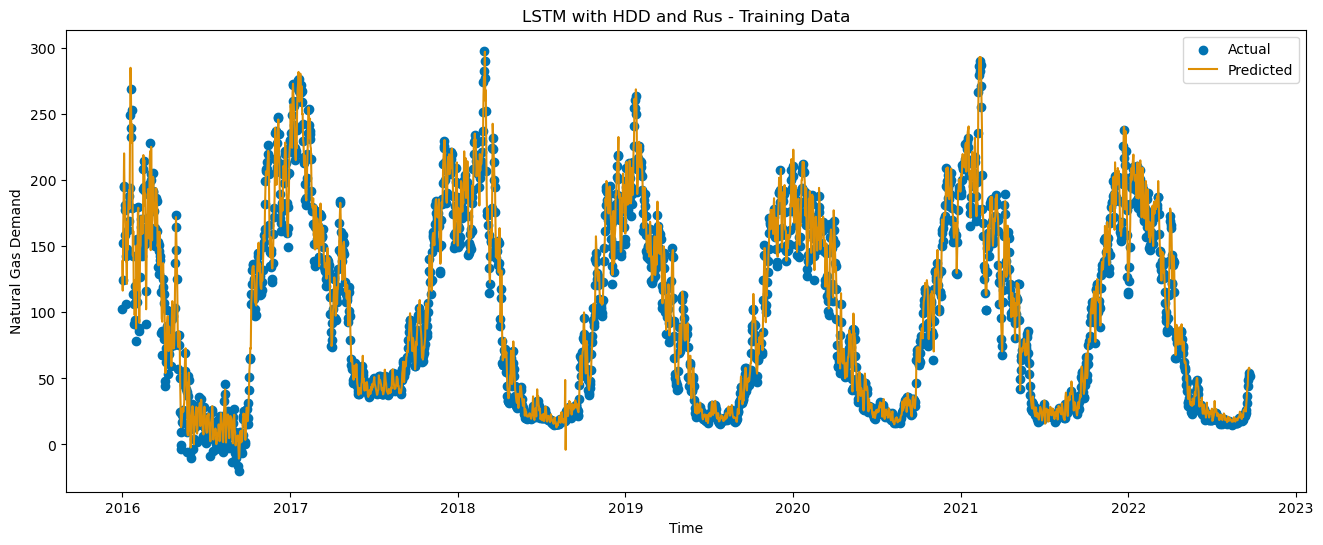

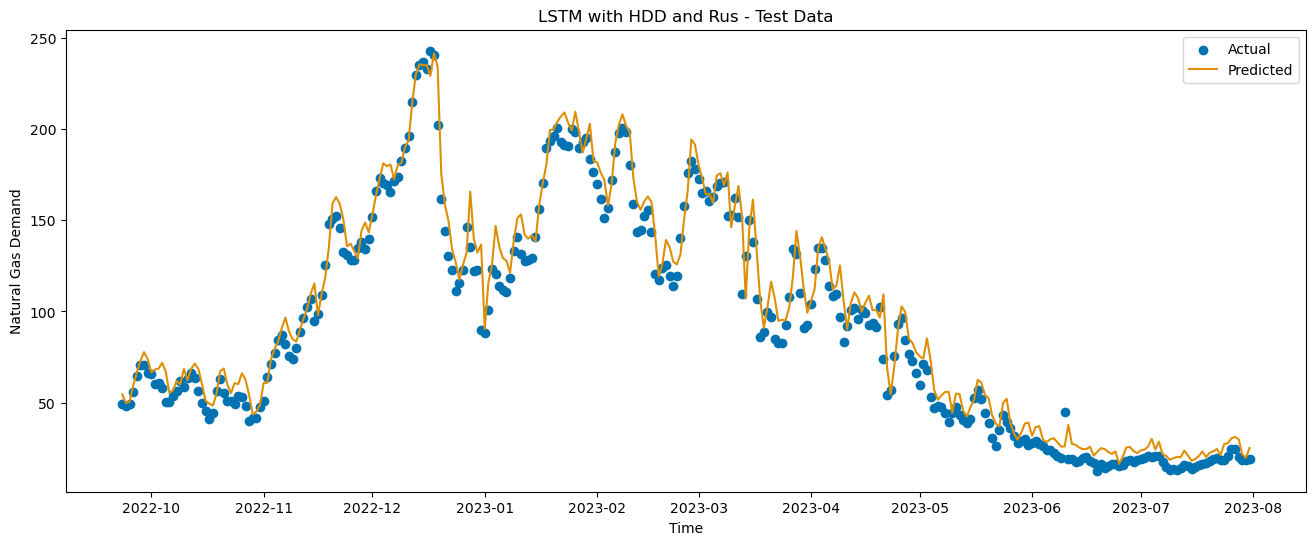

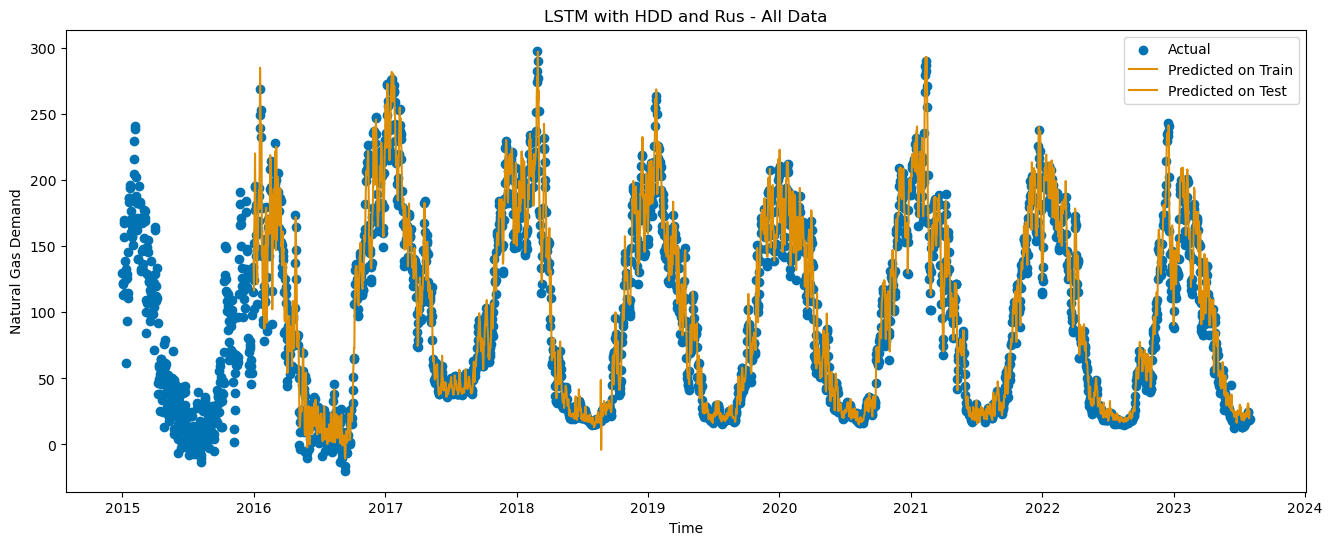

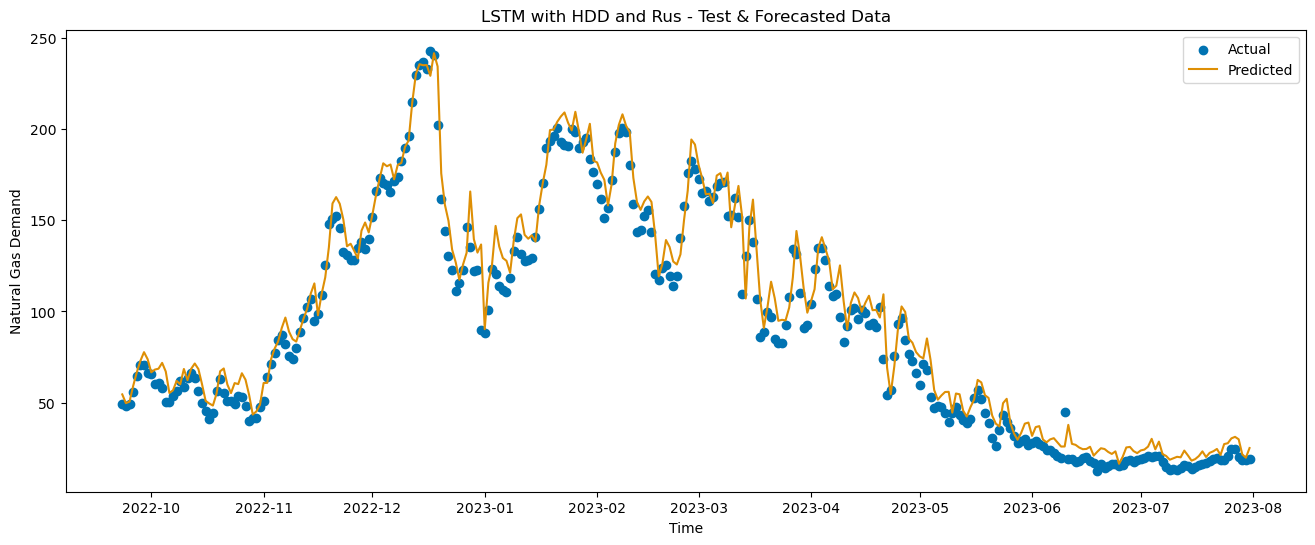

1/1 [==============================] - 0s 28ms/step


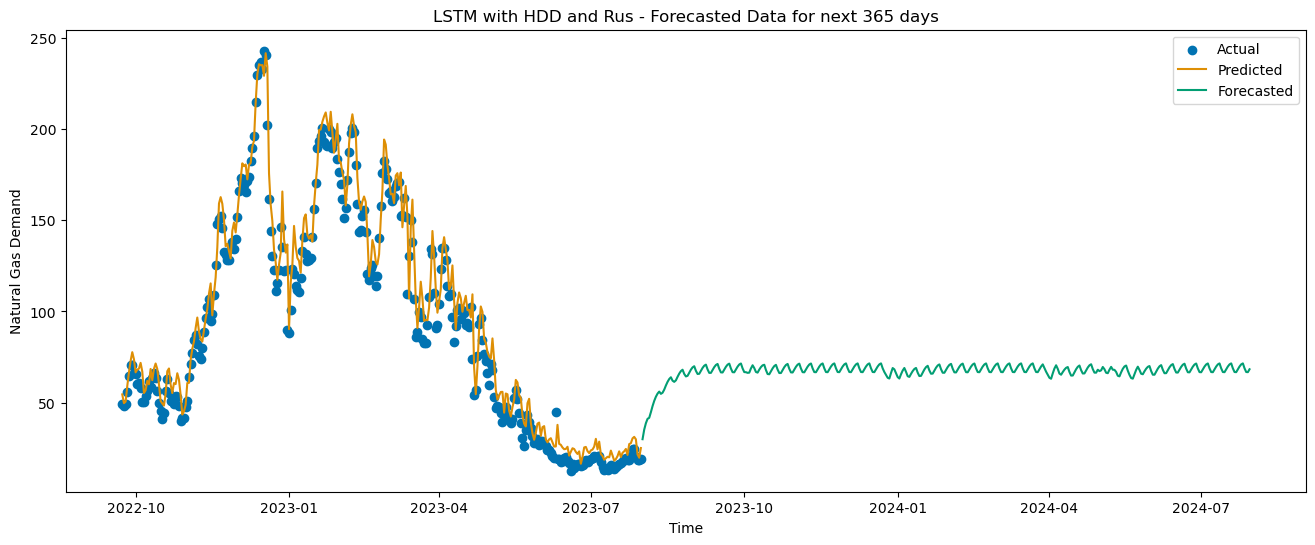

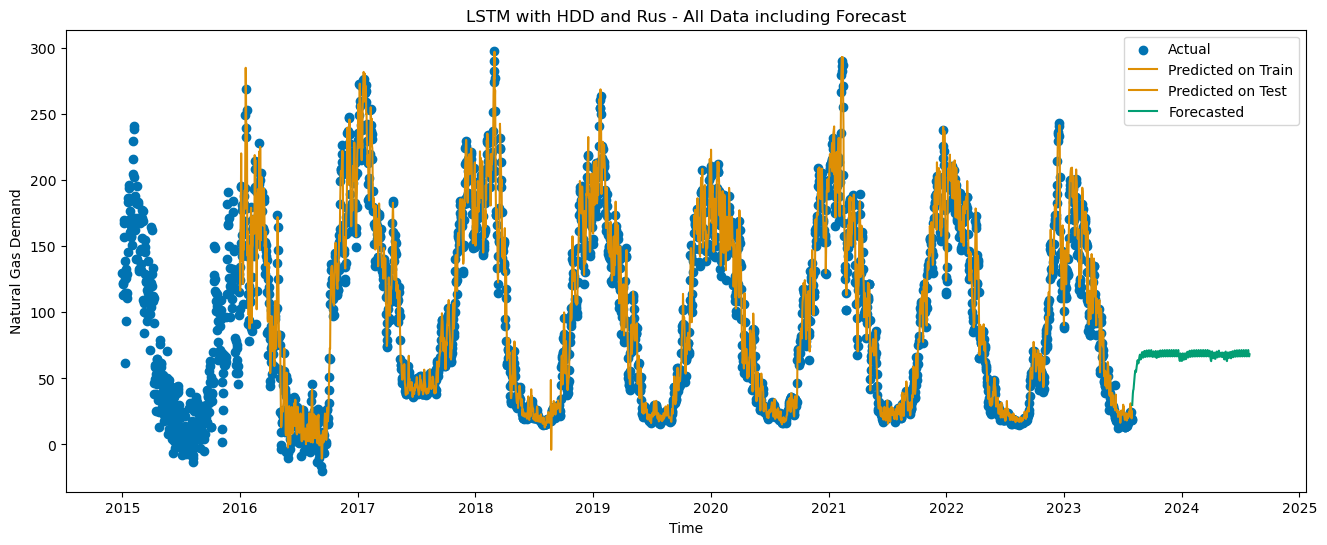

Execution Time for LDZ - LSTM with HDD and Rus: 5845.35 seconds
Evaluation based on variables: ['LDZ', 'HDD', 'HDD-1', 'Rus', 'War', 'Month', 'Workday', 'DE wind', 'DE solar', 'FR nuclear']
Training MAPE: 29.7452%
Testing MAPE: 15.1978%
Training RMSE: 9.7191
Testing RMSE: 11.1051
Training R2 score: 0.9814
Testing R2 score: 0.9658
Training MAE: 6.6969
Testing MAE: 8.5845


In [41]:
# LTSM with multiple explanatory variables
# LDZ 300

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 365
type_ngd = 'LDZ'
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','EU storage','DE solar','EU LNG','THE price', 'DE IND index','EU LNG','UK NL production','African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','DE IND index', 'FR nuclear','THE price']  # Add more variables as needed
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','FR nuclear']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-05 01:34:22.824482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 01:34:22.825223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 01:34:22.825721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

88/88 [==============================] - 4s 34ms/step - loss: 0.0124
Epoch 2/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0052
Epoch 3/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0042
Epoch 4/50
88/88 [==============================] - 3s 36ms/step - loss: 0.0036
Epoch 5/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0030
Epoch 6/50
88/88 [==============================] - 3s 36ms/step - loss: 0.0026
Epoch 7/50
88/88 [==============================] - 3s 36ms/step - loss: 0.0024
Epoch 8/50
88/88 [==============================] - 4s 40ms/step - loss: 0.0020
Epoch 9/50
88/88 [==============================] - 4s 46ms/step - loss: 0.0019
Epoch 10/50
88/88 [==============================] - 4s 46ms/step - loss: 0.0016
Epoch 11/50
88/88 [==============================] - 4s 41ms/step - loss: 0.0017
Epoch 12/50
88/88 [==============================] - 3s 38ms/step - loss: 0.0015
Epoch 13/50
88/88 [=============================

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-05 01:42:37.665919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 01:42:37.666574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 01:42:37.667227: I tensor

10/10 [==============================] - 0s 9ms/step


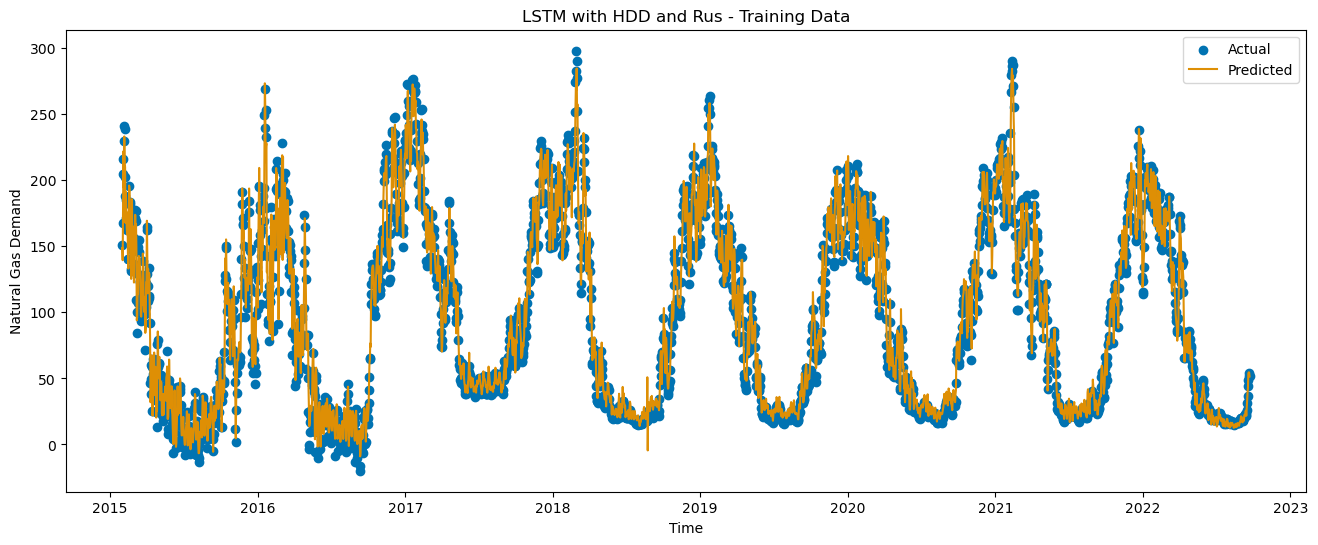

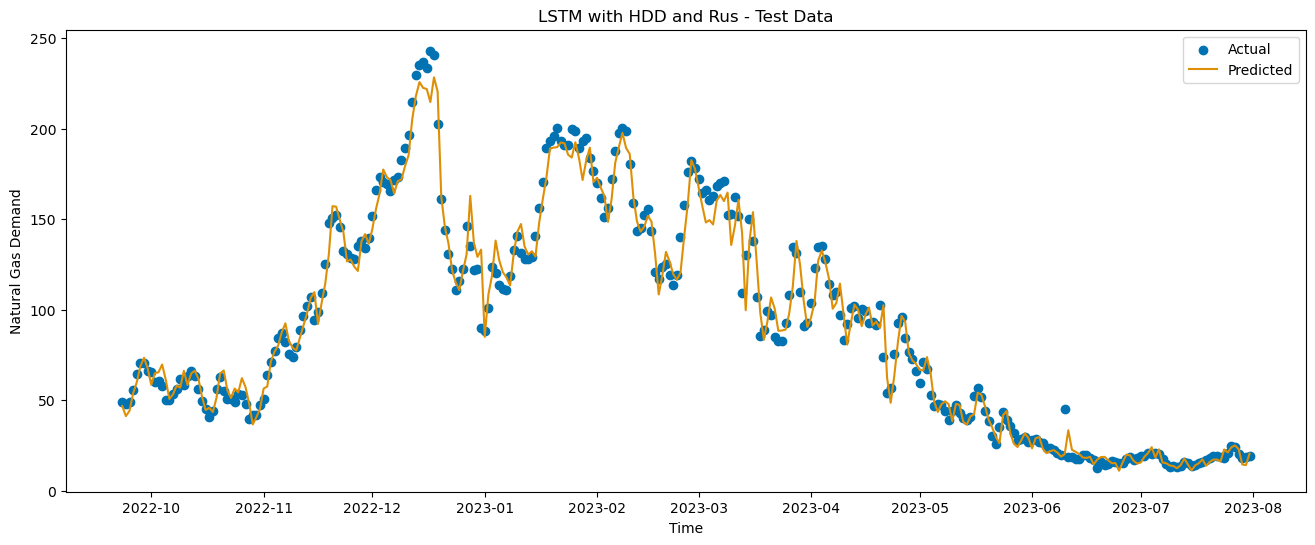

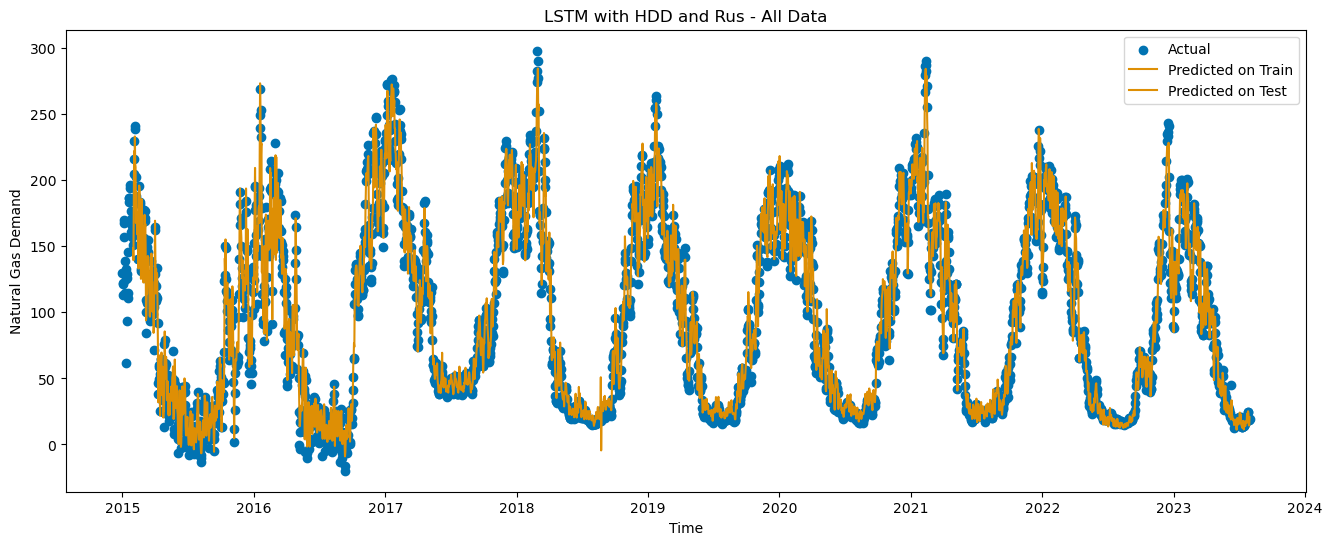

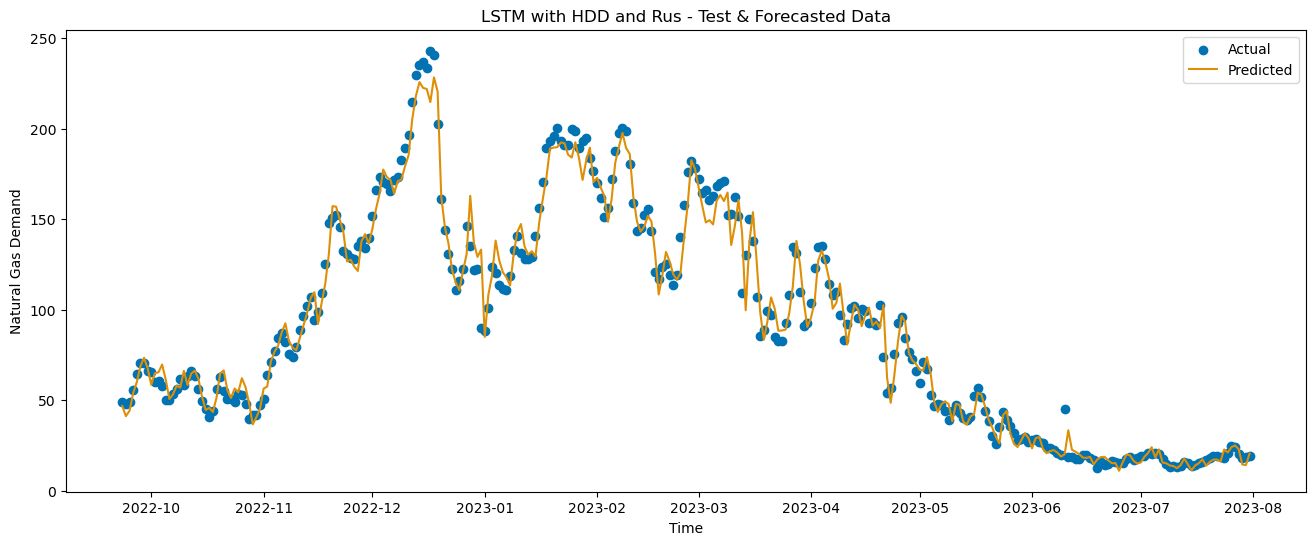

1/1 [==============================] - 0s 10ms/step


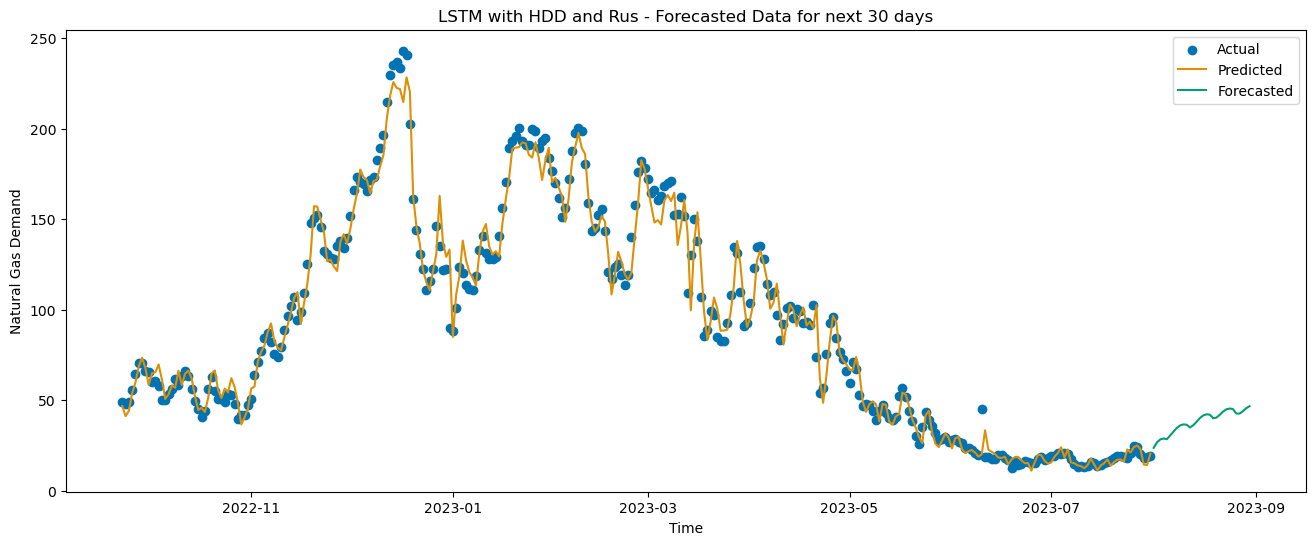

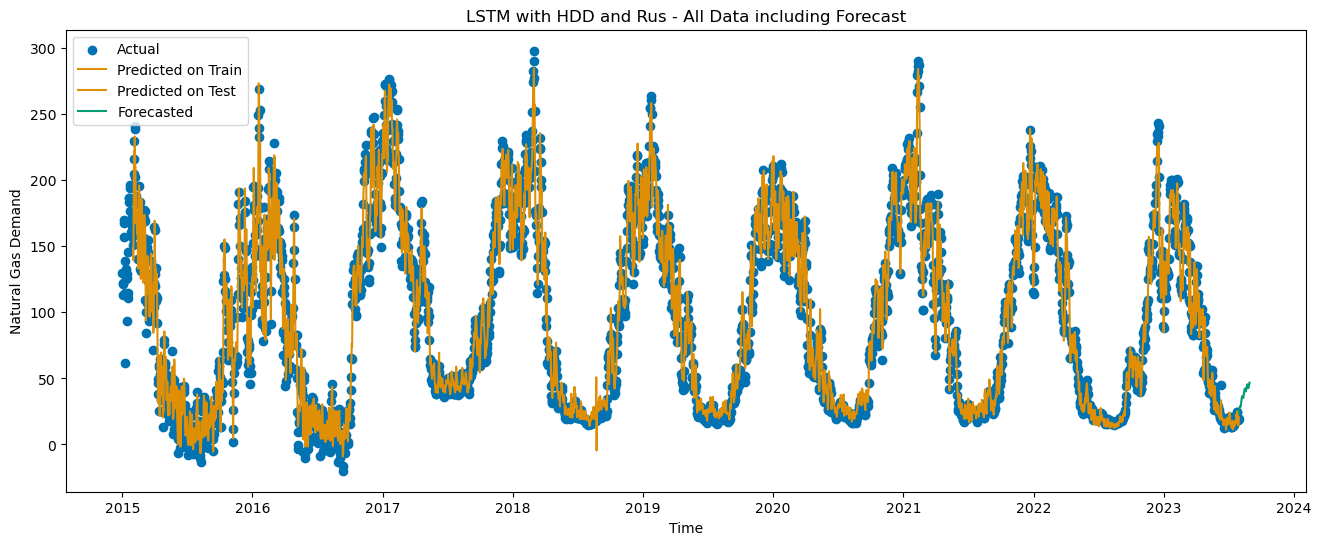

Execution Time for LDZ - LSTM with HDD and Rus: 497.37 seconds
Evaluation based on variables: ['LDZ', 'HDD', 'HDD-1', 'Rus', 'War', 'Month', 'Workday', 'DE wind', 'DE solar', 'FR nuclear']
Training MAPE: 34.4958%
Testing MAPE: 8.4542%
Training RMSE: 10.0105
Testing RMSE: 8.9135
Training R2 score: 0.9799
Testing R2 score: 0.9779
Training MAE: 7.2642
Testing MAE: 6.4517


In [42]:
# LTSM with multiple explanatory variables
# LDZ 30

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 30
type_ngd = 'LDZ'
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','EU storage','DE solar','EU LNG','THE price', 'DE IND index','EU LNG','UK NL production','African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','DE IND index', 'FR nuclear','THE price']  # Add more variables as needed
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','FR nuclear']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-05 01:42:40.221002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 01:42:40.221585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 01:42:40.222221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 325s 4s/step - loss: 0.0133
Epoch 2/50
77/77 [==============================] - 202s 3s/step - loss: 0.0065
Epoch 3/50
77/77 [==============================] - 32s 413ms/step - loss: 0.0054
Epoch 4/50
77/77 [==============================] - 38s 493ms/step - loss: 0.0048
Epoch 5/50
77/77 [==============================] - 70s 914ms/step - loss: 0.0045
Epoch 6/50
77/77 [==============================] - 982s 13s/step - loss: 0.0040
Epoch 7/50
77/77 [==============================] - 33s 433ms/step - loss: 0.0038
Epoch 8/50
77/77 [==============================] - 970s 13s/step - loss: 0.0035
Epoch 9/50
77/77 [==============================] - 31s 397ms/step - loss: 0.0032
Epoch 10/50
77/77 [==============================] - 31s 399ms/step - loss: 0.0032
Epoch 11/50
77/77 [==============================] - 895s 12s/step - loss: 0.0030
Epoch 12/50
77/77 [==============================] - 31s 405ms/step - loss: 0.0028
Epoch 13/50
77/77 [============

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-05 05:25:11.693329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 05:25:11.693883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 05:25:11.694373: I tensor

10/10 [==============================] - 1s 119ms/step


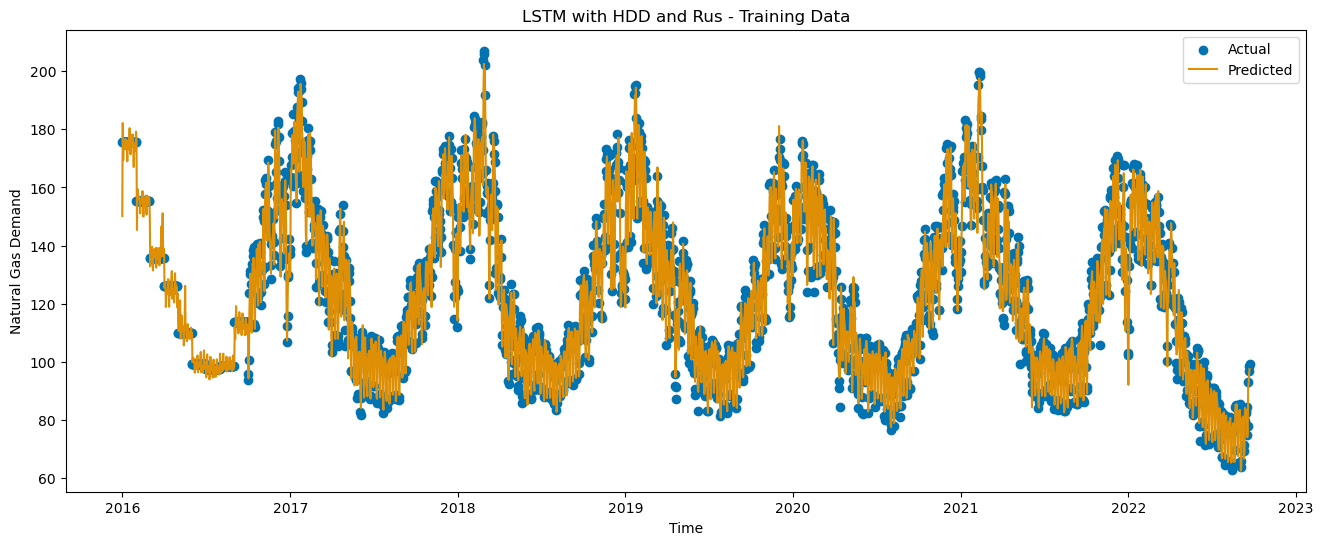

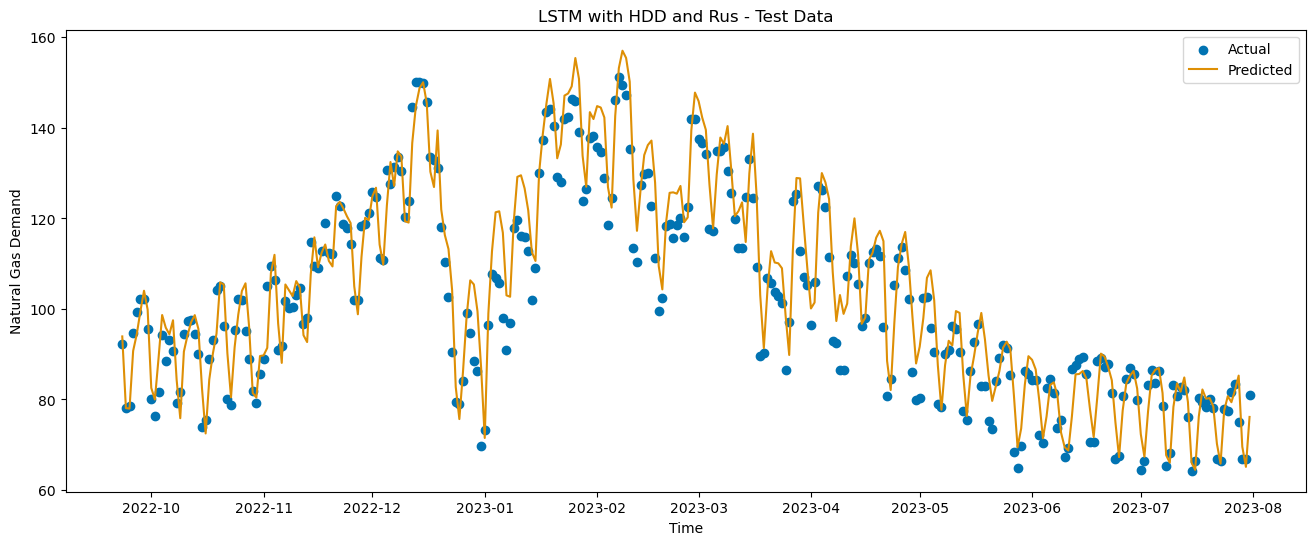

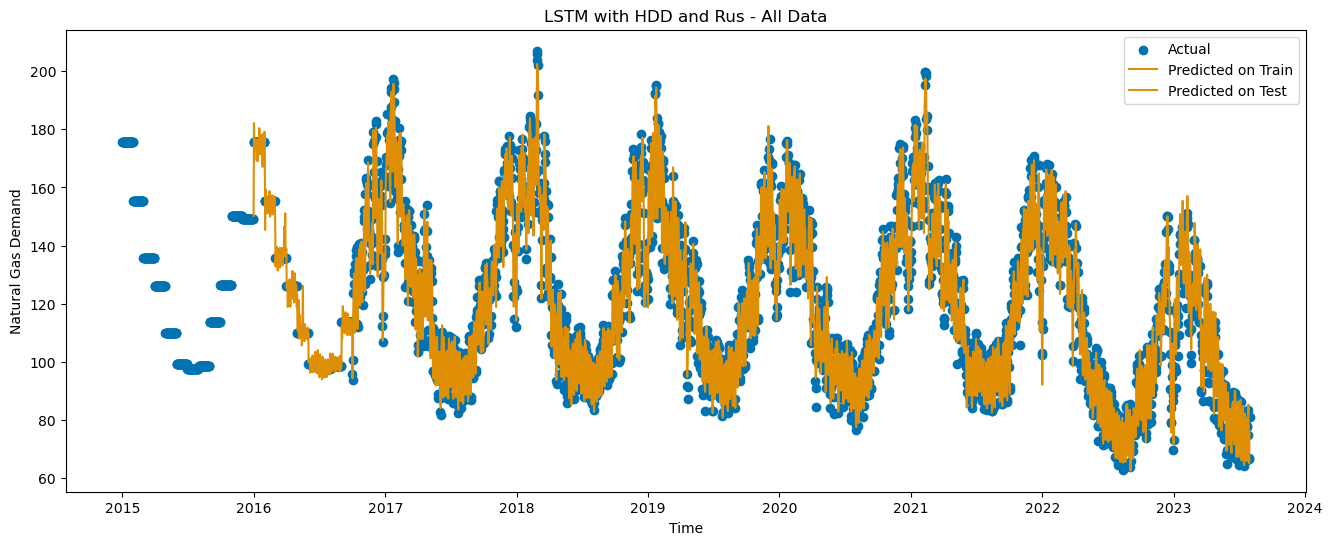

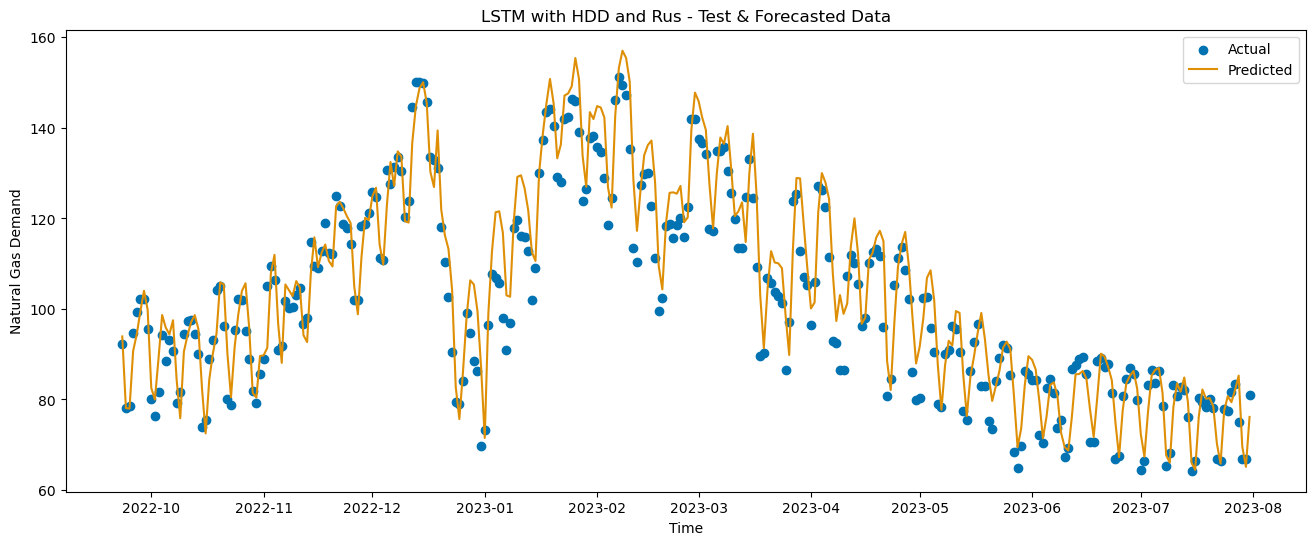

1/1 [==============================] - 0s 28ms/step


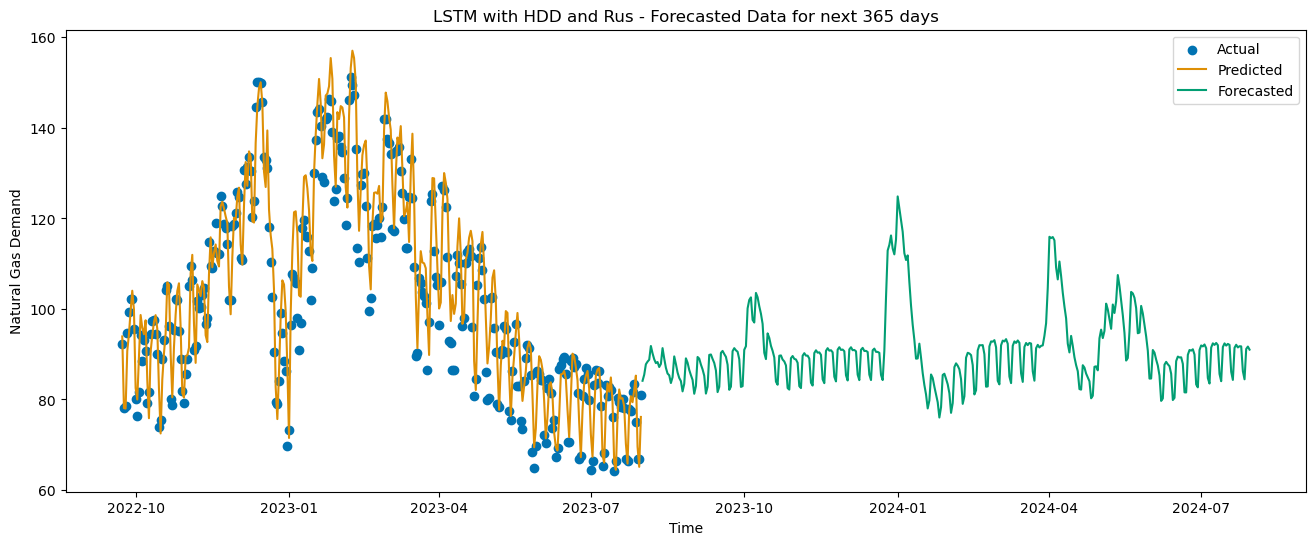

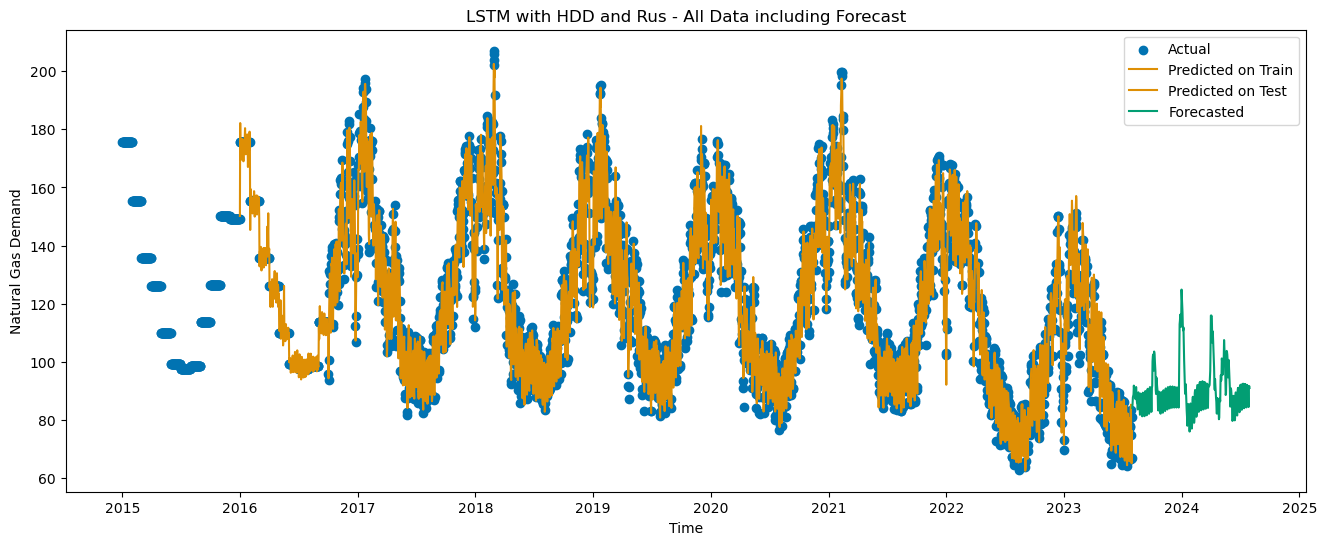

Execution Time for IND - LSTM with HDD and Rus: 13378.03 seconds
Evaluation based on variables: ['IND', 'HDD', 'HDD-1', 'Rus', 'War', 'Month', 'Workday', 'DE wind', 'DE solar', 'DE IND index', 'FR nuclear', 'THE price']
Training MAPE: 2.5123%
Testing MAPE: 5.2742%
Training RMSE: 4.3437
Testing RMSE: 6.7297
Training R2 score: 0.9756
Testing R2 score: 0.9042
Training MAE: 3.1291
Testing MAE: 5.2249


In [43]:
# LTSM with multiple explanatory variables
# IND 300

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 365
type_ngd = 'IND'
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','EU storage','DE solar','EU LNG','THE price', 'DE IND index','EU LNG','UK NL production','African TAP']  # Add more variables as needed
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','DE IND index', 'FR nuclear','THE price']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-05 05:25:38.276487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 05:25:38.277234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 05:25:38.277733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

88/88 [==============================] - 4s 32ms/step - loss: 0.0131
Epoch 2/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0063
Epoch 3/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0056
Epoch 4/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0053
Epoch 5/50
88/88 [==============================] - 3s 34ms/step - loss: 0.0043
Epoch 6/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0038
Epoch 7/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0036
Epoch 8/50
88/88 [==============================] - 3s 35ms/step - loss: 0.0035
Epoch 9/50
88/88 [==============================] - 4s 40ms/step - loss: 0.0033
Epoch 10/50
88/88 [==============================] - 4s 50ms/step - loss: 0.0032
Epoch 11/50
88/88 [==============================] - 4s 46ms/step - loss: 0.0030
Epoch 12/50
88/88 [==============================] - 4s 41ms/step - loss: 0.0029
Epoch 13/50
88/88 [=============================

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-05 05:43:41.462584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 05:43:41.463189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 05:43:41.463747: I tensor

10/10 [==============================] - 0s 10ms/step


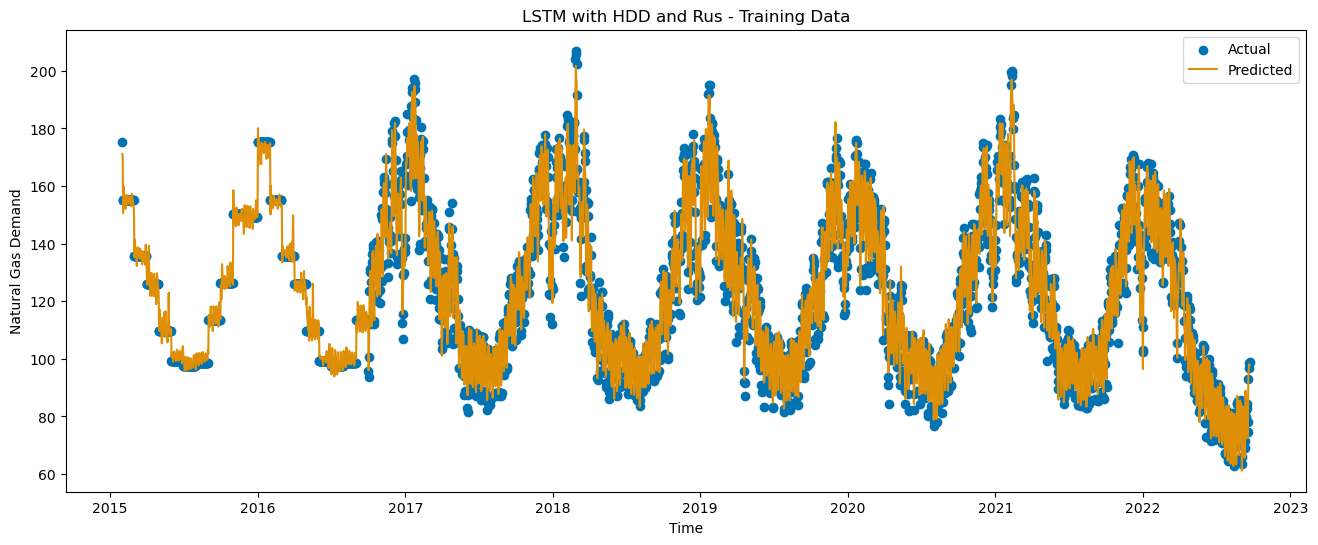

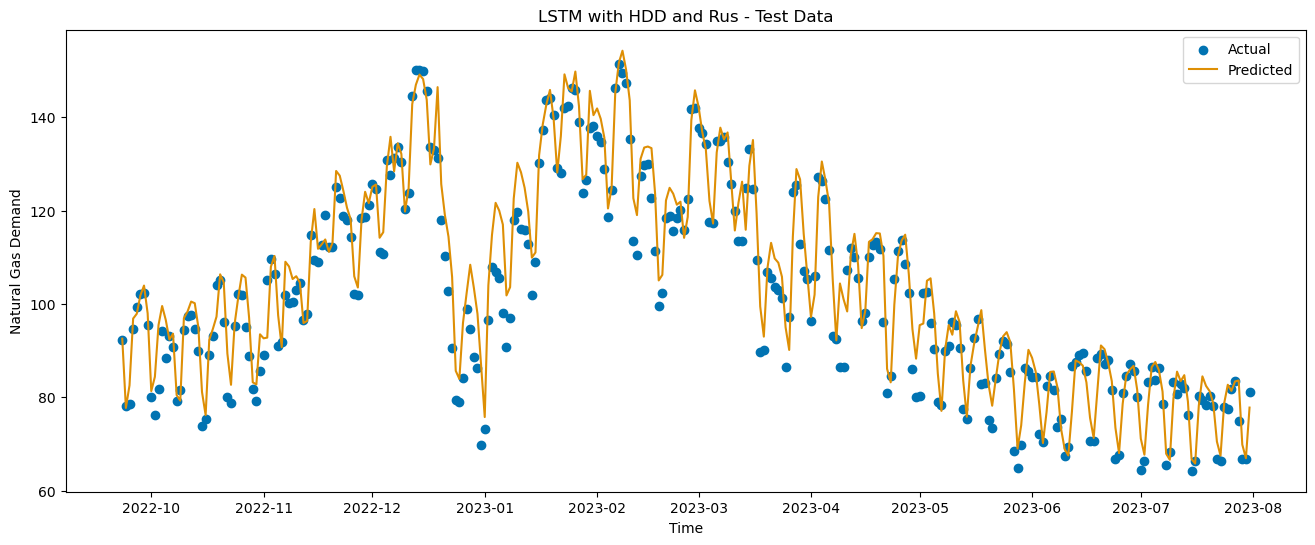

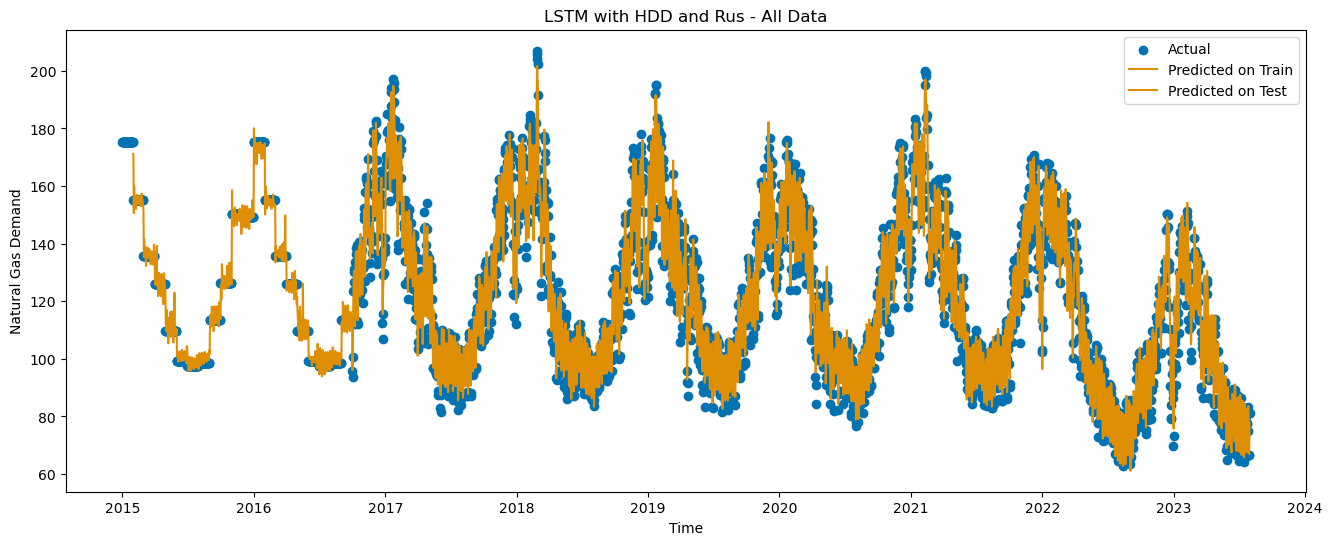

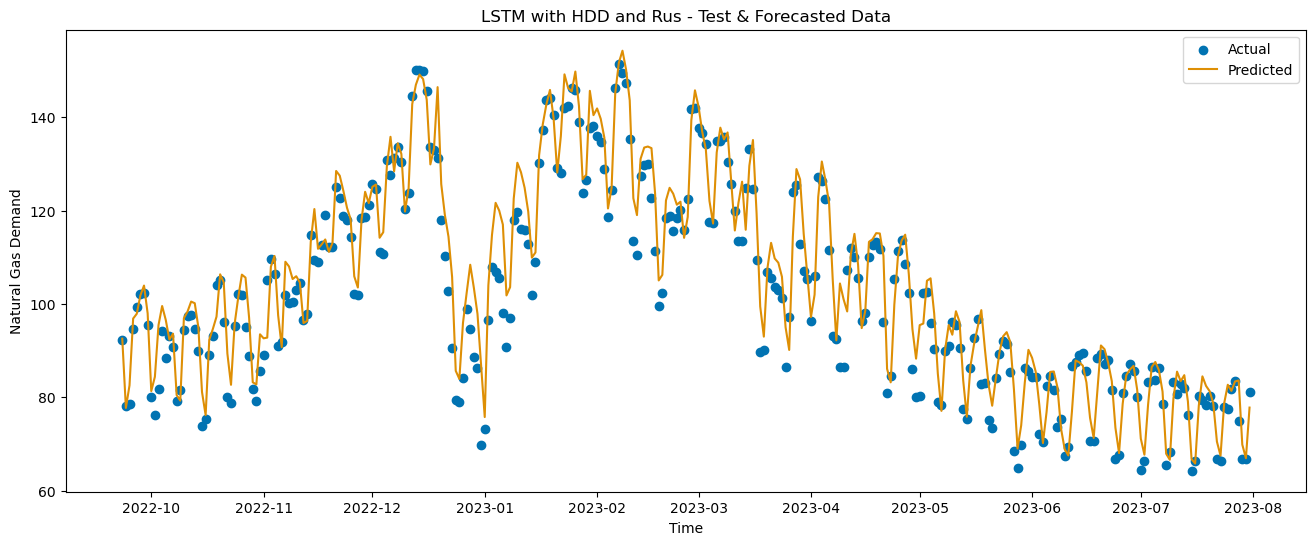

1/1 [==============================] - 0s 9ms/step


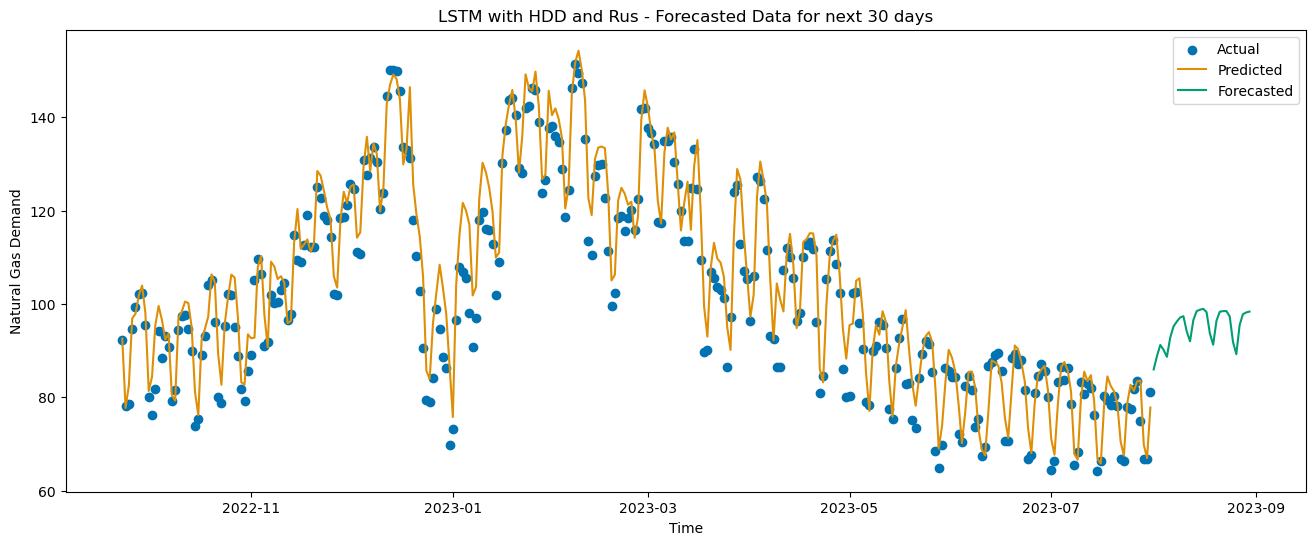

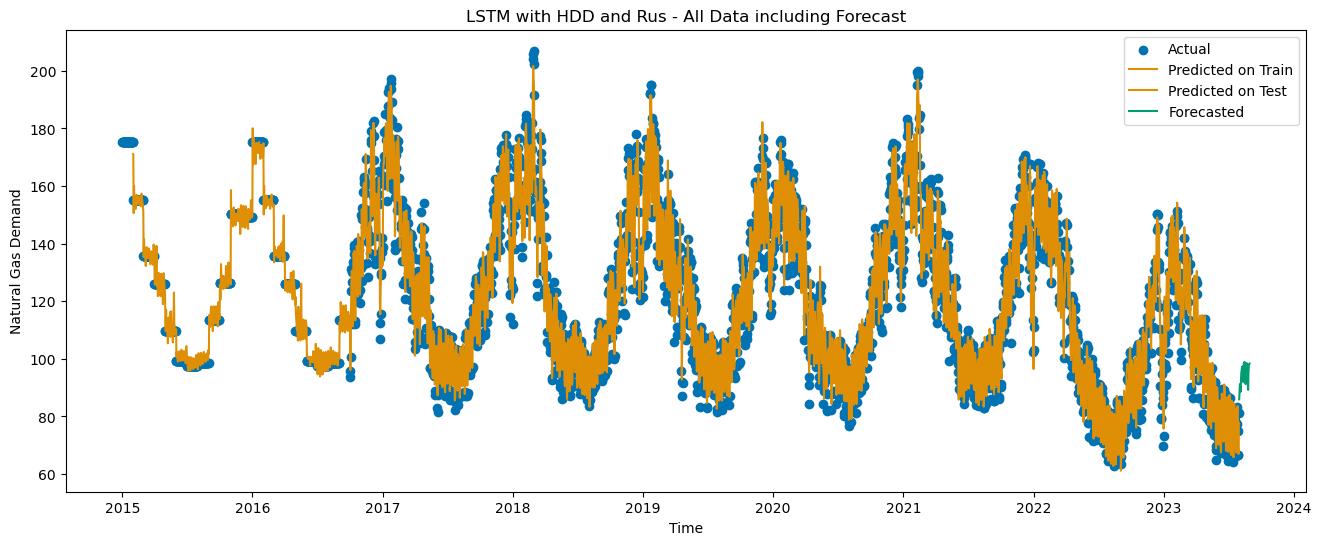

Execution Time for IND - LSTM with HDD and Rus: 2052.00 seconds
Evaluation based on variables: ['IND', 'HDD', 'HDD-1', 'Rus', 'War', 'Month', 'Workday', 'DE wind', 'DE solar', 'DE IND index', 'FR nuclear', 'THE price']
Training MAPE: 2.6231%
Testing MAPE: 4.6486%
Training RMSE: 4.4274
Testing RMSE: 5.9806
Training R2 score: 0.9732
Testing R2 score: 0.9244
Training MAE: 3.2001
Testing MAE: 4.5009


In [44]:
# LTSM with multiple explanatory variables
# IND 300

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 30
type_ngd = 'IND'
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','EU storage','DE solar','EU LNG','THE price', 'DE IND index','EU LNG','UK NL production','African TAP']  # Add more variables as needed
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','Workday','DE wind','DE solar','DE IND index', 'FR nuclear','THE price']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-05 05:59:50.338335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 05:59:50.339020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 05:59:50.339578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

70/70 [==============================] - 31s 419ms/step - loss: 0.0342
Epoch 2/50
70/70 [==============================] - 1064s 15s/step - loss: 0.0250
Epoch 3/50
70/70 [==============================] - 30s 432ms/step - loss: 0.0235
Epoch 4/50
70/70 [==============================] - 1006s 15s/step - loss: 0.0232
Epoch 5/50
70/70 [==============================] - 28s 395ms/step - loss: 0.0205
Epoch 6/50
70/70 [==============================] - 944s 14s/step - loss: 0.0178
Epoch 7/50
70/70 [==============================] - 28s 394ms/step - loss: 0.0148
Epoch 8/50
70/70 [==============================] - 958s 14s/step - loss: 0.0144
Epoch 9/50
70/70 [==============================] - 30s 425ms/step - loss: 0.0134
Epoch 10/50
70/70 [==============================] - 191s 3s/step - loss: 0.0122
Epoch 11/50
70/70 [==============================] - 28s 401ms/step - loss: 0.0118
Epoch 12/50
70/70 [==============================] - 500s 7s/step - loss: 0.0117
Epoch 13/50
70/70 [===========

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-05 08:37:23.236954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 08:37:23.237630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 08:37:23.238193: I tensor

9/9 [==============================] - 1s 124ms/step


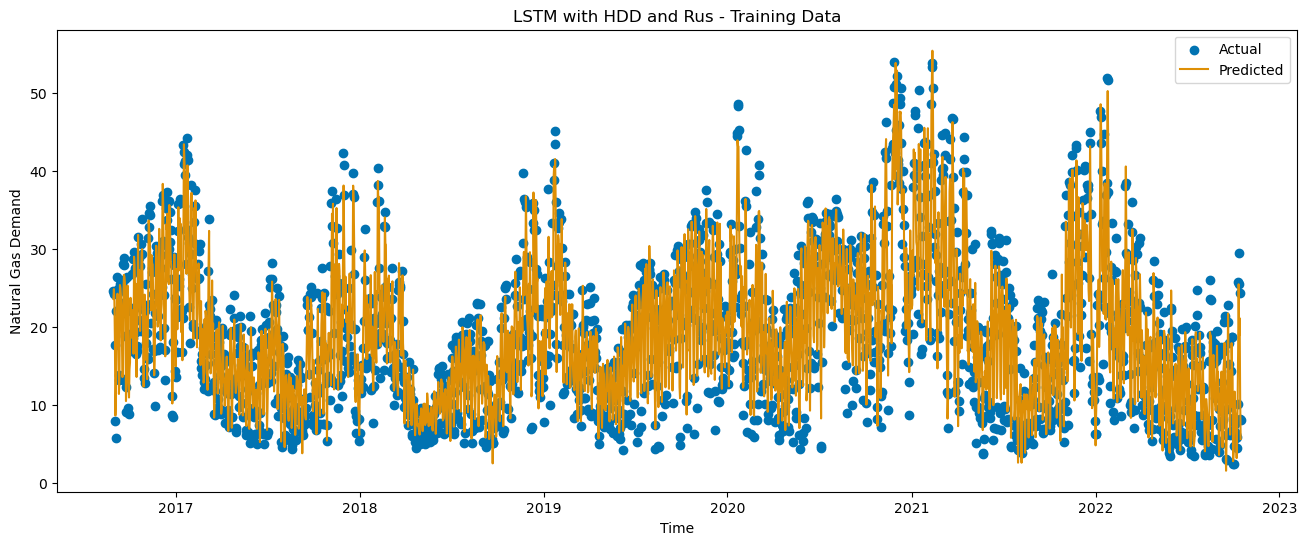

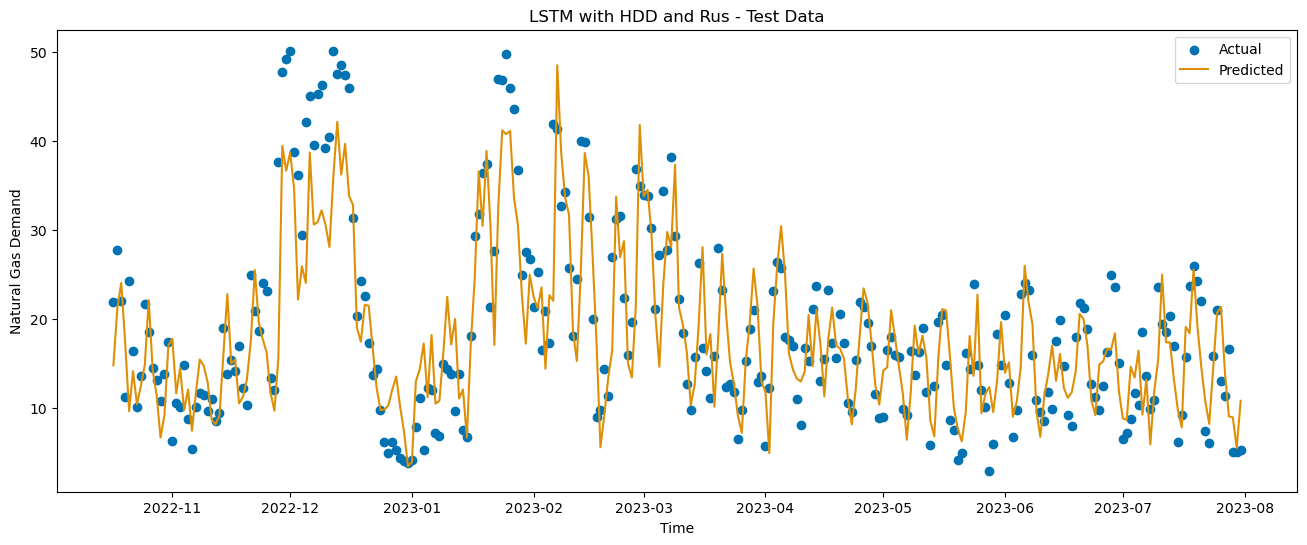

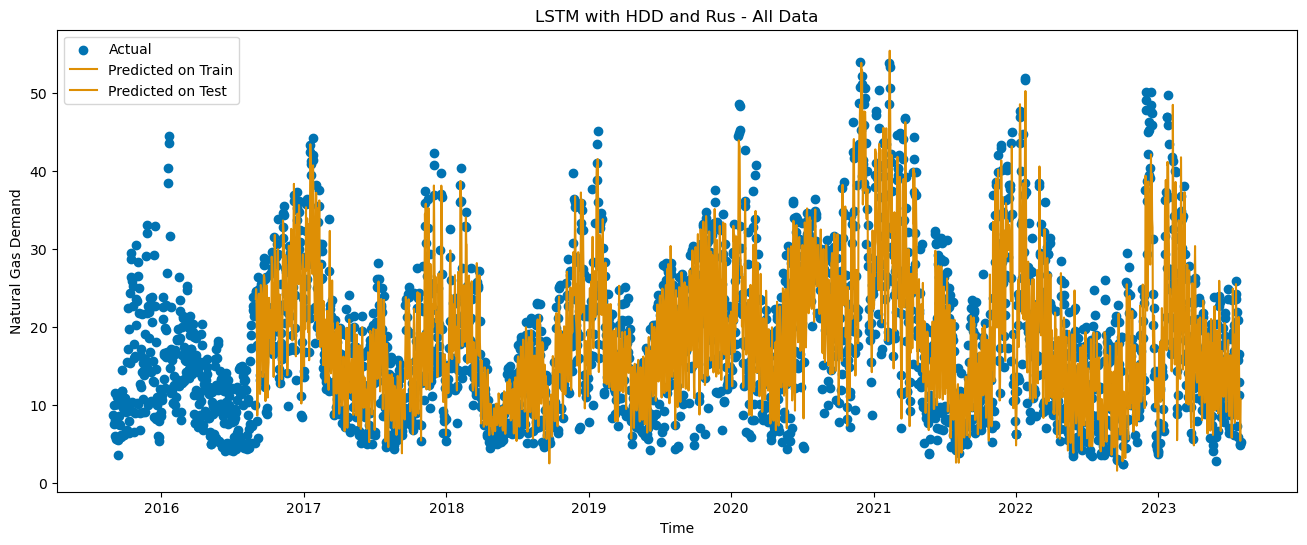

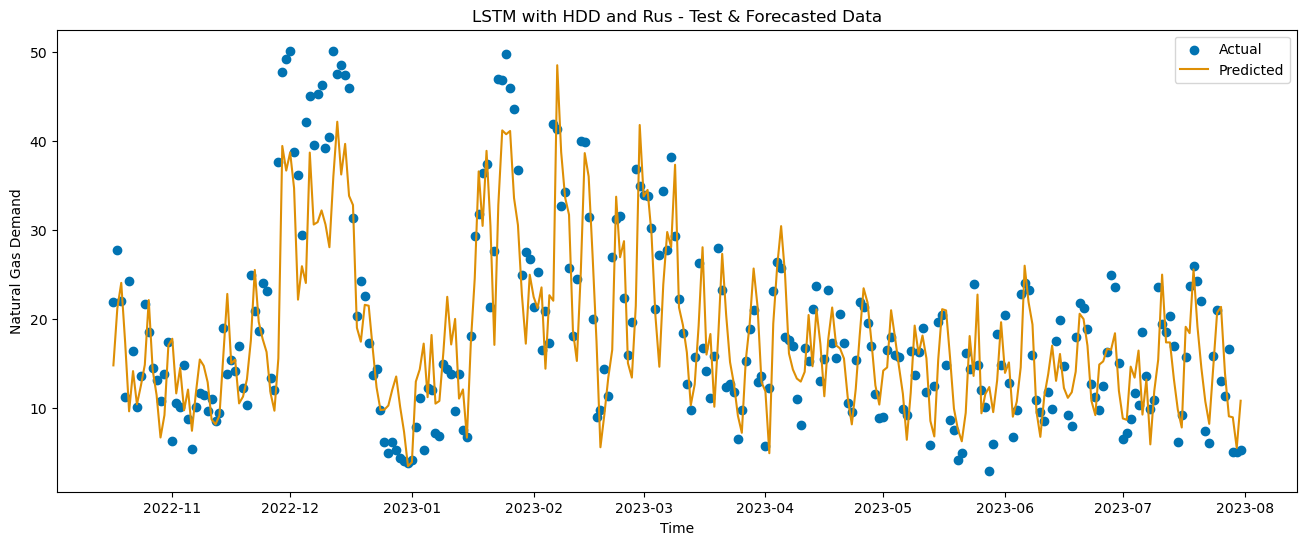

1/1 [==============================] - 0s 29ms/step


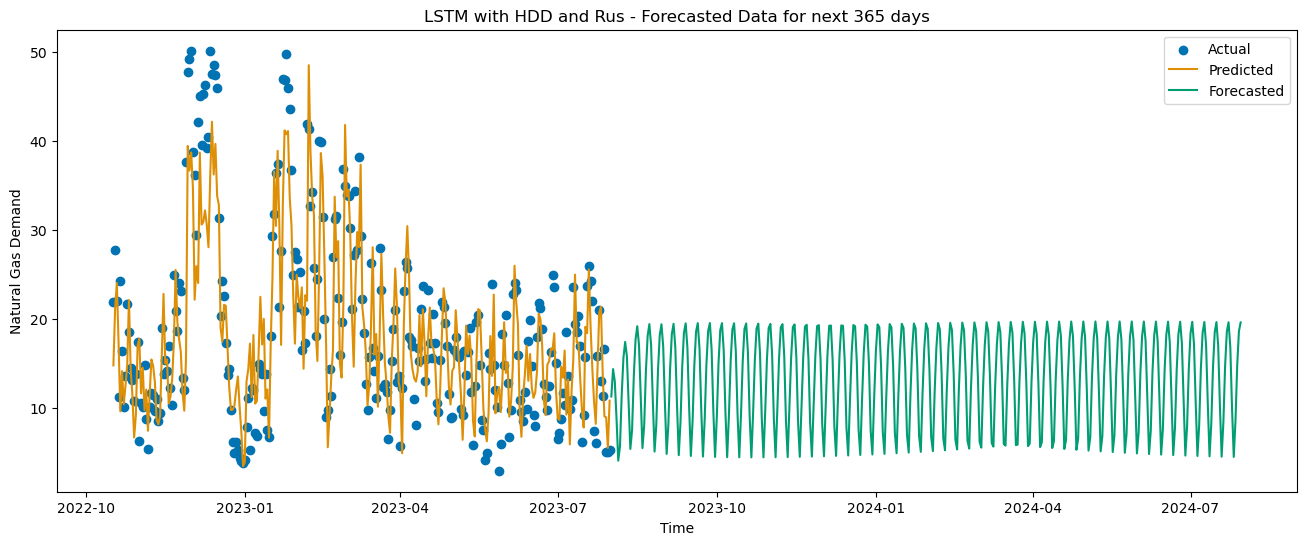

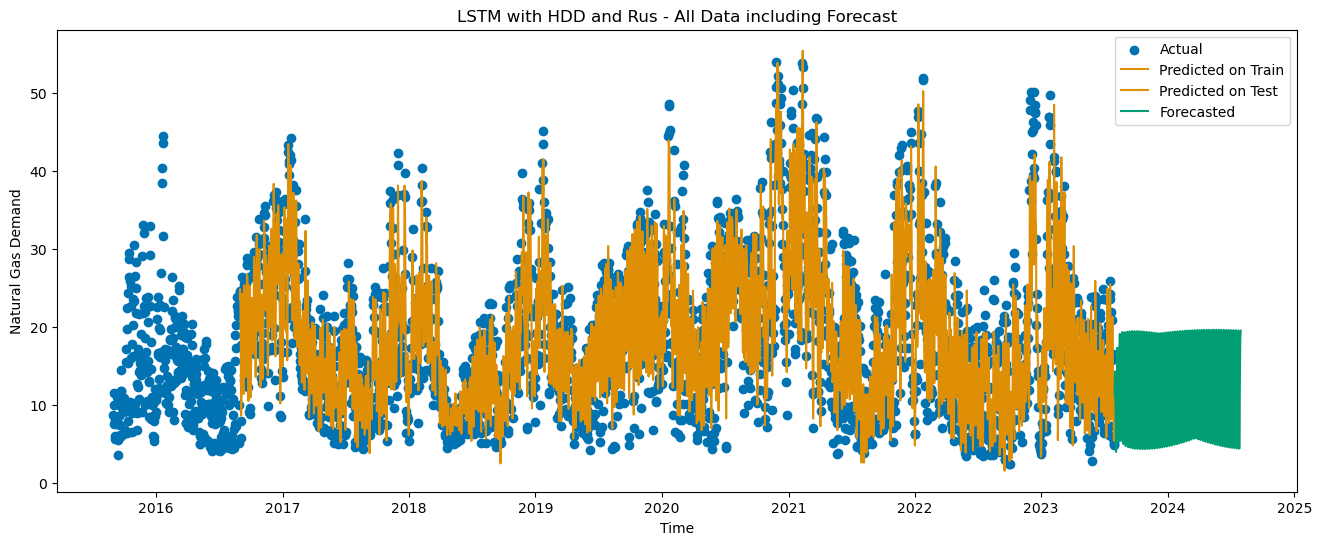

Execution Time for GTP - LSTM with HDD and Rus: 9478.51 seconds
Evaluation based on variables: ['GTP', 'HDD', 'HDD-1', 'Rus', 'War', 'Month', 'DE wind', 'DE solar', 'FR nuclear', 'EU storage', 'EU LNG', 'THE price', 'DE IND index', 'EU LNG', 'UK NL production', 'African TAP']
Training MAPE: 23.1532%
Testing MAPE: 29.9137%
Training RMSE: 4.4950
Testing RMSE: 5.9645
Training R2 score: 0.7945
Testing R2 score: 0.7073
Training MAE: 3.4687
Testing MAE: 4.6178


In [45]:
# LTSM with multiple explanatory variables
# GTP 300

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 365
type_ngd = 'GTP'
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','DE wind','DE solar','FR nuclear','EU storage','EU LNG','THE price','DE IND index','EU LNG','UK NL production','African TAP']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))


Epoch 1/50


2023-11-05 08:37:48.876878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 08:37:48.877638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 08:37:48.878111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

81/81 [==============================] - 5s 35ms/step - loss: 0.0318
Epoch 2/50
81/81 [==============================] - 3s 36ms/step - loss: 0.0227
Epoch 3/50
81/81 [==============================] - 3s 36ms/step - loss: 0.0221
Epoch 4/50
81/81 [==============================] - 3s 36ms/step - loss: 0.0205
Epoch 5/50
81/81 [==============================] - 3s 37ms/step - loss: 0.0198
Epoch 6/50
81/81 [==============================] - 3s 36ms/step - loss: 0.0163
Epoch 7/50
81/81 [==============================] - 3s 37ms/step - loss: 0.0139
Epoch 8/50
81/81 [==============================] - 3s 37ms/step - loss: 0.0127
Epoch 9/50
81/81 [==============================] - 3s 36ms/step - loss: 0.0122
Epoch 10/50
81/81 [==============================] - 3s 36ms/step - loss: 0.0117
Epoch 11/50
81/81 [==============================] - 3s 37ms/step - loss: 0.0112
Epoch 12/50
81/81 [==============================] - 3s 36ms/step - loss: 0.0105
Epoch 13/50
81/81 [=============================

/Users/binbai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-11-05 08:40:18.418549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-05 08:40:18.419100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-05 08:40:18.419685: I tensor

9/9 [==============================] - 0s 11ms/step


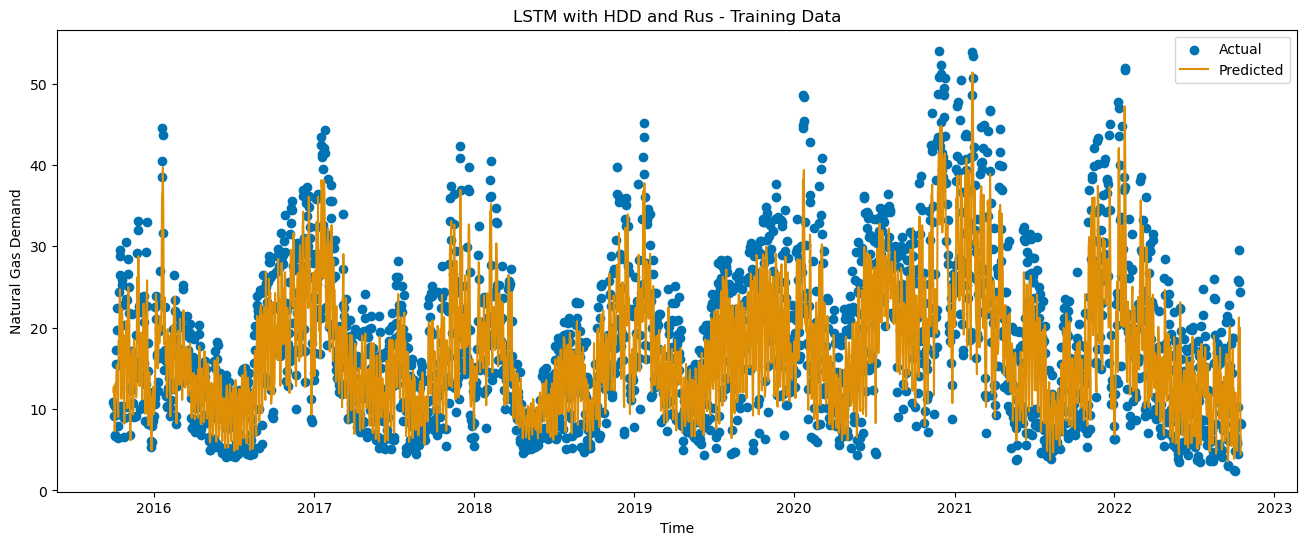

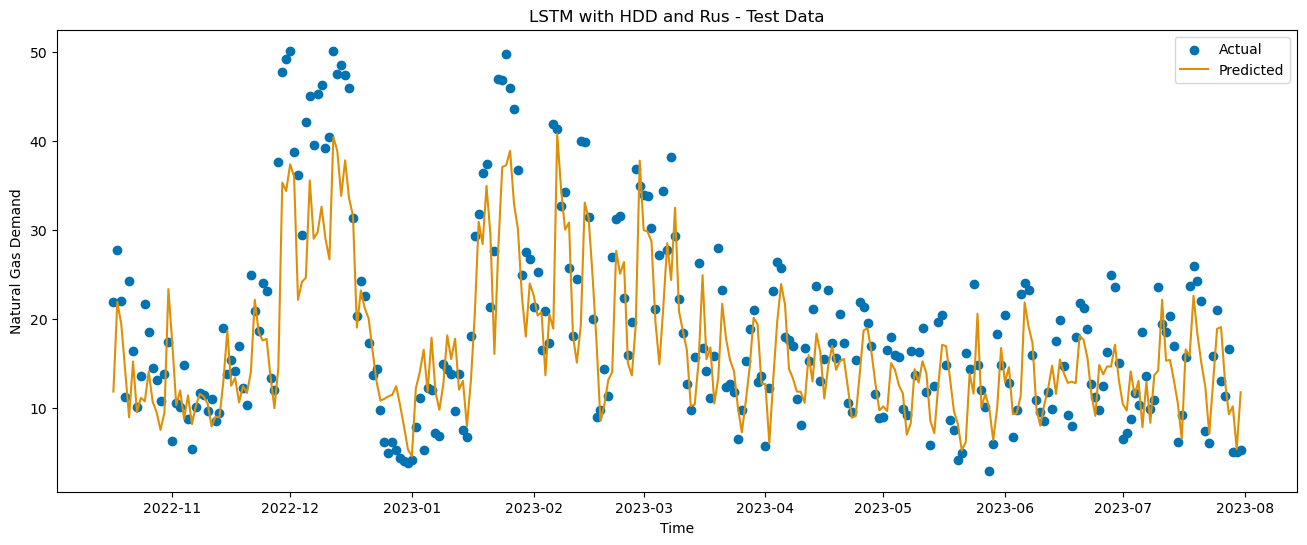

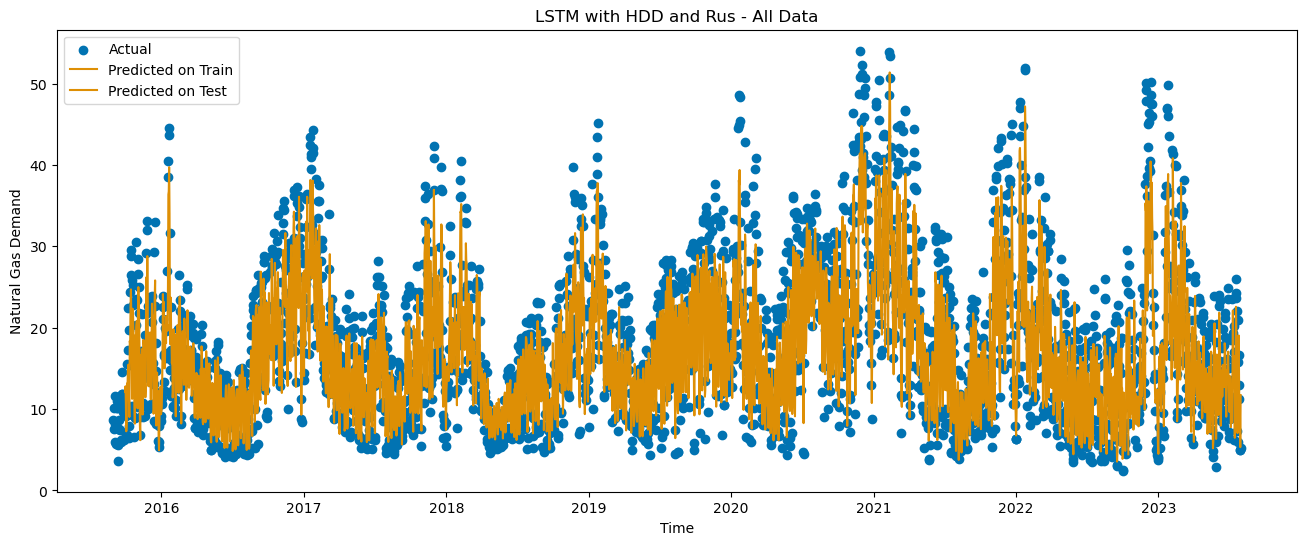

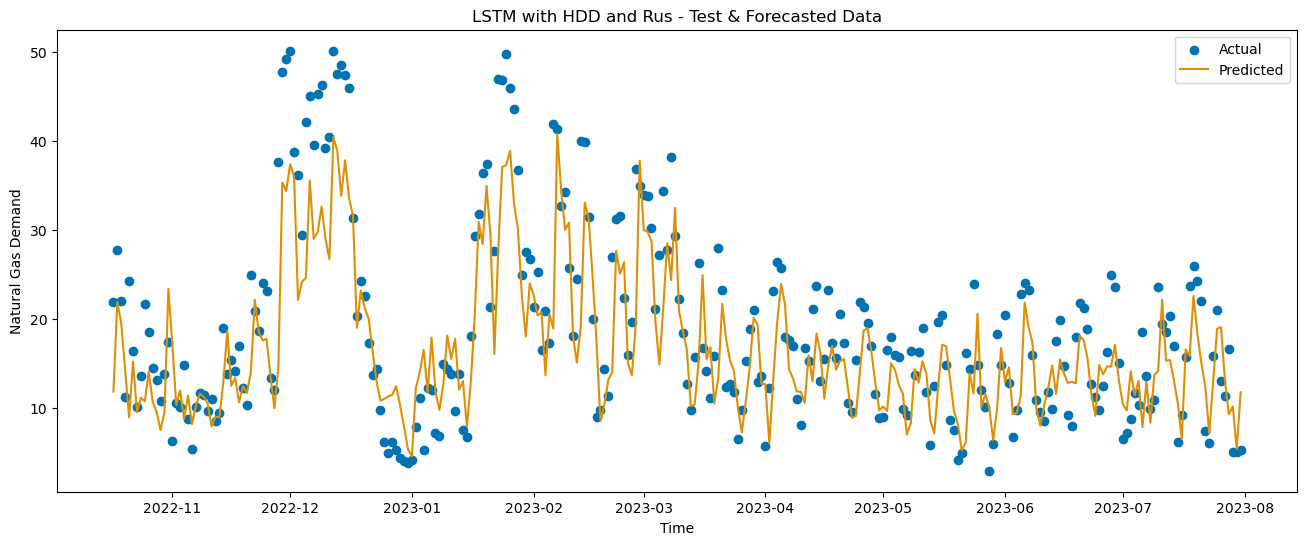

1/1 [==============================] - 0s 10ms/step


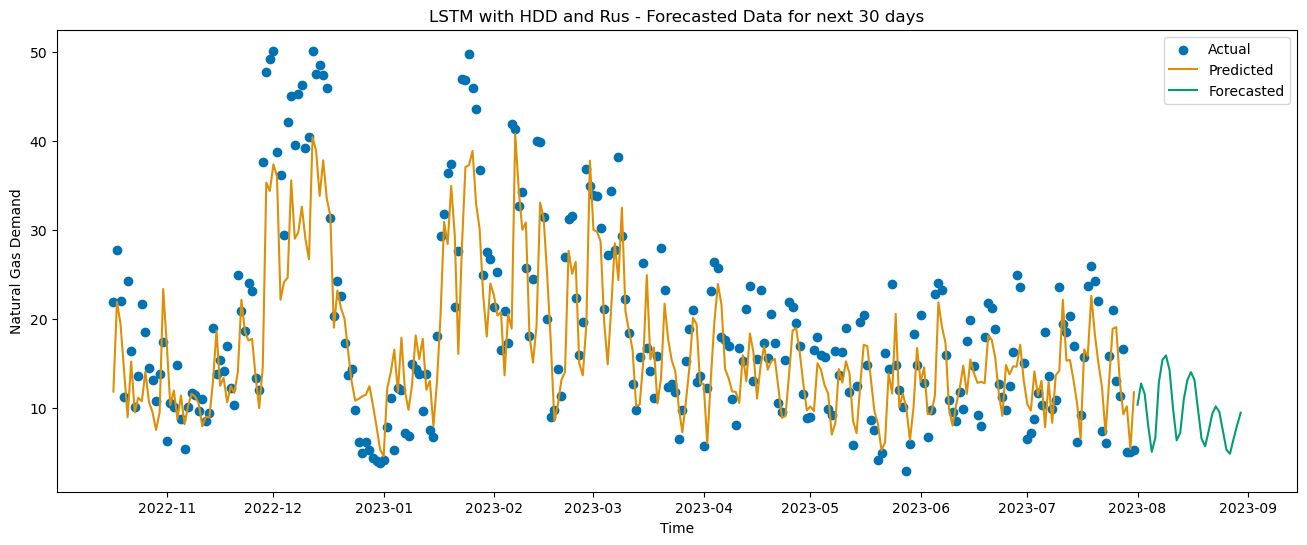

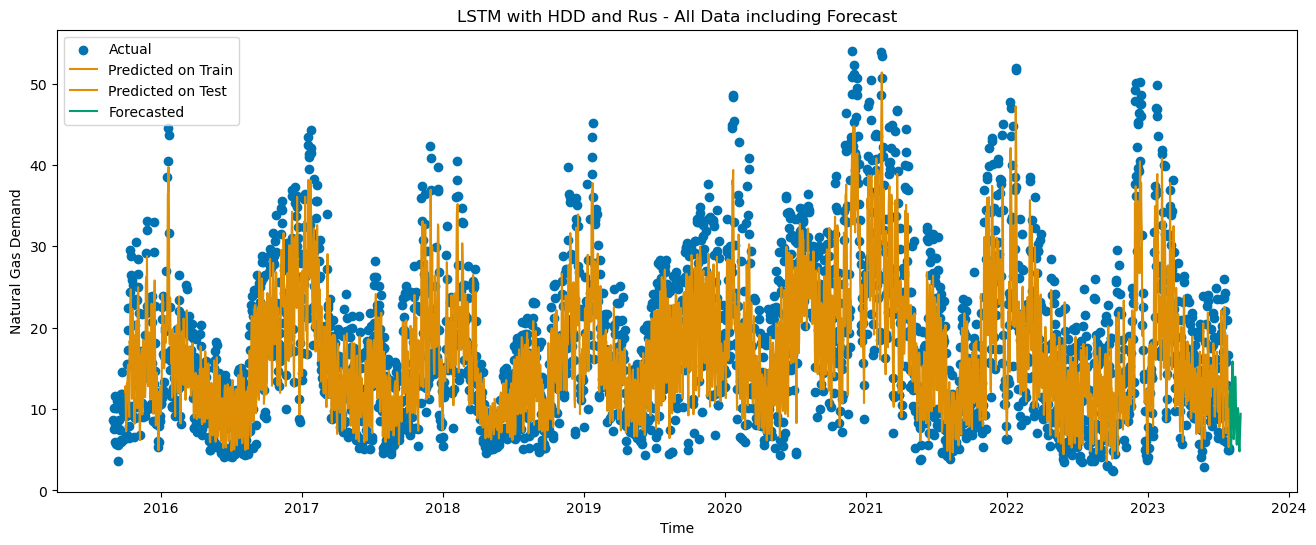

Execution Time for GTP - LSTM with HDD and Rus: 152.16 seconds
Evaluation based on variables: ['GTP', 'HDD', 'HDD-1', 'Rus', 'War', 'Month', 'DE wind', 'DE solar', 'FR nuclear', 'EU storage', 'EU LNG', 'THE price', 'DE IND index', 'UK NL production', 'African TAP']
Training MAPE: 20.9349%
Testing MAPE: 29.5774%
Training RMSE: 4.4898
Testing RMSE: 6.4683
Training R2 score: 0.7869
Testing R2 score: 0.6557
Training MAE: 3.3978
Testing MAE: 4.8496


In [46]:
# LTSM with multiple explanatory variables
# GTP 300

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time  # Importing the time module
import holidays

# Parameters
test_ratio = 0.1
nr_lastdays = 30
type_ngd = 'GTP'
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Workday','Month','DE IND index']  # Add more variables as needed
#explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','EU storage','DE solar','EU LNG','THE price', 'African TAP']  # Add more variables as needed
explanatory_vars = [type_ngd, 'HDD', 'HDD-1', 'Rus','War','Month','DE wind','DE solar','FR nuclear','EU storage','EU LNG','THE price','DE IND index','UK NL production','African TAP']  # Add more variables as needed

ngd_data = pd.read_csv('daily_NGD.csv', delimiter=',')
ngd_data['Date'] = pd.to_datetime(ngd_data['Date'])
ngd_data.dropna(subset=explanatory_vars, inplace=True)

start_time = time.time()

# Train-test split
test_start_dt = round(len(ngd_data) * (1 - test_ratio)) + 1
train = ngd_data.iloc[:test_start_dt]
test = ngd_data.iloc[test_start_dt:]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[explanatory_vars])
scaled_test = scaler.transform(test[explanatory_vars])

# Create data structure with timesteps
X_train = []
y_train = []
for i in range(nr_lastdays, len(train)):
    X_train.append(scaled_train[i-nr_lastdays:i])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM
num_features = len(explanatory_vars)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

# LSTM model
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(LSTM(units=200))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Test data preparation
dataset_total = pd.concat((train[explanatory_vars], test[explanatory_vars]), axis=0)
inputs = dataset_total.values[len(dataset_total) - len(test) - nr_lastdays:]
inputs = scaler.transform(inputs)

X_test = []
for i in range(nr_lastdays, nr_lastdays + len(test)):
    X_test.append(inputs[i-nr_lastdays:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Predictions
# Prepare for inverse scaling
predicted_train = model.predict(X_train)
predicted_demand = model.predict(X_test)

# Add dummy columns to match the number of explanatory variables
dummy_cols = np.zeros((predicted_train.shape[0], len(explanatory_vars) - 1))
predicted_train = scaler.inverse_transform(np.hstack((predicted_train, dummy_cols)))[:, 0]

dummy_cols_test = np.zeros((predicted_demand.shape[0], len(explanatory_vars) - 1))
predicted_demand = scaler.inverse_transform(np.hstack((predicted_demand, dummy_cols_test)))[:, 0]

# Plotting
colors = sns.color_palette("colorblind")

# 1. Actual vs Predicted on Training Data
plt.figure(figsize=(16, 6))
plt.scatter(train['Date'][nr_lastdays:], train[type_ngd].iloc[nr_lastdays:], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Training Data")
plt.legend()
plt.show()

# 2. Actual vs Predicted on Test Data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test Data")
plt.legend()
plt.show()

# 3. Actual, Predicted, and Forecasted on All Data
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data")
plt.legend()
plt.show()

# 4. Actual (Test) vs Predicted & Forecasted
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Test & Forecasted Data")
plt.legend()
plt.show()

# Forecasting
forecasted_output = []
current_input = inputs[-nr_lastdays:].tolist()  # Start with the last nr_lastdays of the dataset
german_holidays = holidays.Germany(years=np.datetime64(ngd_data['Date'].iloc[-1]).astype('datetime64[Y]').astype(int).item())

for day in range(nr_lastdays):
    current_date = ngd_data['Date'].iloc[-1] + pd.Timedelta(days=day + 1)

    # Set 'Rus' to the last observed value
    rus_index = explanatory_vars.index('Rus')
    current_input[-1][rus_index] = inputs[-1][rus_index]
    
    # Set 'Workday' if it's in the list
    if 'Workday' in explanatory_vars:
        workday_index = explanatory_vars.index('Workday')
        current_input[-1][workday_index] = 0 if current_date in german_holidays or current_date.weekday() >= 5 else 1

    ## Set 'War' to the last observed value
    if 'War' in explanatory_vars:
        war_index = explanatory_vars.index('War')
        current_input[-1][war_index] = inputs[-1][war_index]

    current_input_array = np.array(current_input, dtype=float)  # Convert to float type
    current_input_reshaped = np.reshape(current_input_array, (1, current_input_array.shape[0], len(explanatory_vars)))

    forecasted_demand = model.predict(current_input_reshaped)  # Make a prediction
    
    # Determine the number of columns to append
    num_cols_to_append = scaler.min_.shape[0] - forecasted_demand.shape[1]

    # Inverse transform the prediction
    forecasted_demand_inverse = scaler.inverse_transform(np.hstack((forecasted_demand, np.zeros((forecasted_demand.shape[0], num_cols_to_append)))))[:, 0]

    # Store the prediction
    forecasted_output.append(forecasted_demand_inverse[0])
    
    # Update current_input with the new forecasted value and drop the first day's values
    new_input = [forecasted_demand[0][0]] + current_input[-1][1:]  # Use the previous day's values except for the forecasted value
    current_input.append(new_input)
    current_input.pop(0)  # remove the first day's values
        
# Generate dates for the forecasted days
forecast_dates = pd.date_range(start=ngd_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=nr_lastdays)

# 5. Forecasted data
plt.figure(figsize=(16, 6))
plt.scatter(test['Date'], test[type_ngd], color=colors[0], label="Actual")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - Forecasted Data for next {} days".format(nr_lastdays))
plt.legend()
plt.show()

# 6. Actual, Predicted, and Forecasted on All Data including Forecast
plt.figure(figsize=(16, 6))
plt.scatter(ngd_data['Date'], ngd_data[type_ngd], color=colors[0], label="Actual")
plt.plot(train['Date'][nr_lastdays:], predicted_train, color=colors[1], label="Predicted on Train")
plt.plot(test['Date'], predicted_demand[-len(test):], color=colors[1], label="Predicted on Test")
plt.plot(forecast_dates, forecasted_output, color=colors[2], label="Forecasted")
plt.xlabel("Time")
plt.ylabel("Natural Gas Demand")
plt.title("LSTM with HDD and Rus - All Data including Forecast")
plt.legend()
plt.show()

end_time = time.time()  # Ending the timer
print(f"Execution Time for {type_ngd} - LSTM with HDD and Rus: {end_time - start_time:.2f} seconds")

# Evaluation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_mape = mean_absolute_percentage_error(test[type_ngd], predicted_demand)
train_rmse = np.sqrt(mean_squared_error(train[type_ngd].iloc[nr_lastdays:], predicted_train))
train_r2 = r2_score(train[type_ngd].iloc[nr_lastdays:], predicted_train)
train_mae = mean_absolute_error(train[type_ngd].iloc[nr_lastdays:], predicted_train)
test_rmse = np.sqrt(mean_squared_error(test[type_ngd], predicted_demand))
test_r2 = r2_score(test[type_ngd], predicted_demand)
test_mae = mean_absolute_error(test[type_ngd], predicted_demand)

# Print the results
print(f"Evaluation based on variables: {explanatory_vars}")
print("Training MAPE: {:.4f}%".format(train_mape))
print("Testing MAPE: {:.4f}%".format(test_mape))
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))
print("Training R2 score: {:.4f}".format(train_r2))
print("Testing R2 score: {:.4f}".format(test_r2))
print("Training MAE: {:.4f}".format(train_mae))
print("Testing MAE: {:.4f}".format(test_mae))
